# Исследование алгоритмов для регулярных запросов #

## Постановка задачи ##

Проанализировать производительность алгоритмов решения задачи достижимости.

Исследуются следующие задачи достижимости, решаемые в предыдущих работах.
1) Достижимость между всеми парами вершин.
2) Достижимость для каждой из заданного множества стартовых вершин.

Вопросы, на которые необходимо ответить в ходе исследования.
1) Какое представление разреженных матриц и векторов лучше подходит для каждой из решаемых задач?
2) Начиная с какого размера стартового множества выгоднее решать задачу для всех пар и выбирать нужные?

## Описание исследуемых решений ##

### tensor based rpq (Достижимость между всеми парами вершин) ###

```Python
def tensor_based_rpq(regex: str, graph: MultiDiGraph, start_nodes: set[int],
      final_nodes: set[int]) -> set[tuple[int, int]]:
   pass
```

Алгоритм поиска путей в графе, удовлетворяющих заданному регулярному выражению, основанный на тензорном произведении матриц смежности dfa(построенного по regex) и nfa(построенного по graph, start_nodes, final_nodes). 

### multi source bfs based rpq (Достижимость для каждой из заданного множества стартовых вершин) ###

```Python
def ms_bfs_based_rpq(regex: str, graph: MultiDiGraph, start_nodes: set[int],
         final_nodes: set[int]) -> set[tuple[int, int]]:
  pass
```

Алгоритм поиска путей в графе, удовлетворяющих заданному регулярному выражению, основанный на multi source bfs.

## Описание набора данных для экспериментов ##

### Графы ###

Для проведения эксперимента были выбраны следующие графы из [набора](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/graphs/index.html): `generations`, `univ`, `foaf`, `wc`, `bzip`, `pr`

- `generations`, `univ`, `foaf` - графы, в которых кол-во ребер > кол-ва вершин
- `wc`, `bzip`, `pr` - графы, в которых кол-во ребер < кол-ва вершин

### Запросы ### 

Для проведения эксперимента были выбраны следующие шаблоны запросов:

1) `l1* (l2 | l3)*`
2) `l1* | l2* | l3*`
3) `l1* l2* l3*`
4) `(l1 l2)* | (l2 l3)*`

`l1` --- самый популярный `label` ребер графа
`l2` --- второй по популярности `label` ребер графа
`l3` --- третий по популярности `label` ребер графа

Для графов, в которых кол-во различных `label` на ребрах меньше трех, возьмем в запросах `l2 == l3`.

### Множества стартовых вершин ###

Для генерации множеств стартовых вершин используется [функция](https://formallanguageconstrainedpathquerying.github.io/CFPQ_Data/reference/graphs/generated/cfpq_data.graphs.utils.multiple_source_utils.html#cfpq_data.graphs.utils.multiple_source_utils.generate_multiple_source).

## Ход эксперимента

### Подготовка

In [1]:
import math

import cfpq_data
import networkx as nx
import numpy as np
import pandas as pd
import timeit
import matplotlib.pyplot as plt

from scipy import sparse
from dataclasses import dataclass
from collections import defaultdict

from algo.typed_rpq import tensor_based_rpq, ms_bfs_based_rpq

import sources directory


In [2]:
GRAPHS_NAMES = ["generations", "univ", "foaf", "wc", "bzip", "pr"]


def get_graph_by_name(name):
    graph_csv = cfpq_data.download(name)
    return cfpq_data.graph_from_csv(graph_csv)


GRAPHS = []

for graph_name in GRAPHS_NAMES:
    GRAPHS.append((graph_name, get_graph_by_name(graph_name)))

[2025-01-27 14:22:28]>INFO>Found graph with name='generations'
[2025-01-27 14:22:28]>INFO>Load archive graph_archive=WindowsPath('C:/Users/tepa46/PycharmProjects/formal-lang-course/.venv/Lib/site-packages/cfpq_data/data/graphs/generations.tar.gz')
[2025-01-27 14:22:28]>INFO>Unzip graph name='generations' to file graph=WindowsPath('C:/Users/tepa46/PycharmProjects/formal-lang-course/.venv/Lib/site-packages/cfpq_data/data/graphs/generations/generations.csv')
[2025-01-27 14:22:28]>INFO>Remove archive graph_archive=WindowsPath('C:/Users/tepa46/PycharmProjects/formal-lang-course/.venv/Lib/site-packages/cfpq_data/data/graphs/generations.tar.gz')
[2025-01-27 14:22:28]>INFO>Load graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x00000157E09601D0> from path=WindowsPath('C:/Users/tepa46/PycharmProjects/formal-lang-course/.venv/Lib/site-packages/cfpq_data/data/graphs/generations/generations.csv')
[2025-01-27 14:22:28]>INFO>Found graph with name='univ'
[2025-01-27 14:22:29]>INFO>Load arc

In [3]:
regex_1 = "l1* ( l2 | l3 )"


def get_regex_1(label1, label2, label3):
    return f"{label1}* ( {label2} | {label3} )"


regex_2 = "l1* | l2* | l3*"


def get_regex_2(label1, label2, label3):
    return f"{label1}* | {label2}* | {label3}*"


regex_3 = "l1* l2* l3*"


def get_regex_3(label1, label2, label3):
    return f"{label1}* {label2}* {label3}*"


regex_4 = "( l1 l2 )* | ( l2 l3 )*"


def get_regex_4(label1, label2, label3):
    return f"( {label1} {label2} )* | ( {label2} {label3} )*"


def get_regexes_info(graph):
    graph_labels = cfpq_data.get_sorted_labels(graph)

    label1 = graph_labels[0]
    label2 = graph_labels[1 % len(graph_labels)]
    label3 = graph_labels[2 % len(graph_labels)]
    return [
        (regex_1, get_regex_1(label1, label2, label3)),
        (regex_2, get_regex_2(label1, label2, label3)),
        (regex_3, get_regex_3(label1, label2, label3)),
        (regex_4, get_regex_4(label1, label2, label3)),
    ]

In [4]:
seed = 42


def generate_start_states_set(graph, number_of_states):
    return cfpq_data.generate_multiple_source(graph, number_of_states, seed=seed)


K = [0.05, 0.2, 1]


def generate_start_states_list(graph):
    start_states = []
    for k in K:
        start_states.append(
            generate_start_states_set(graph, int(graph.number_of_nodes() * k))
        )

    return start_states

In [5]:
RPQ_ALGOS = [tensor_based_rpq, ms_bfs_based_rpq]

SPARSE_MATRICES_TYPES = [
    sparse.csr_matrix,
    sparse.csc_matrix,
    sparse.coo_matrix,
]
SPARSE_MATRICES_TYPES_NAMES = list(
    matrix_type.__name__ for matrix_type in SPARSE_MATRICES_TYPES
)

In [6]:
@dataclass
class RpqComputingResults:
    algorithm_name: str
    graph_name: str
    regex_scheme: str
    start_nodes_number: int
    sparse_matrix_type: str
    mean_time: str
    std_time: str

In [7]:
NUMBER_OF_LAUNCHES = 30

In [8]:
def compute_rpq(
    rpq_algorithm,
    sparse_matrix_type,
    graph: nx.MultiDiGraph,
    graph_name: str,
    regex: str,
    regex_scheme: str,
    start_nodes: set[int],
) -> RpqComputingResults:
    times = []
    for _ in range(NUMBER_OF_LAUNCHES):
        time = timeit.timeit(
            lambda: rpq_algorithm(regex, graph, start_nodes, set(), sparse_matrix_type),
            number=1,
        )
        times.append(time)

    times = sorted(times)[3:-3]
    mean = np.mean(times)
    std = np.std(times)
    order = max(math.ceil(-math.log10(std)), 0)

    return RpqComputingResults(
        rpq_algorithm.__name__,
        graph_name,
        regex_scheme,
        len(start_nodes),
        sparse_matrix_type.__name__,
        f"{mean:.{order}f}",
        f"{std:.{order}f}",
    )

In [9]:
results = []

for algo in RPQ_ALGOS:
    for matrix_type in SPARSE_MATRICES_TYPES:
        for graph_info in GRAPHS:
            graph = graph_info[1]
            graph_name = graph_info[0]
            start_states_list = generate_start_states_list(graph)
            for start_states in start_states_list:
                regexes_info = get_regexes_info(graph)
                for regex_info in regexes_info:
                    regex_scheme = regex_info[0]
                    regex = regex_info[1]
                    results.append(
                        compute_rpq(
                            algo,
                            matrix_type,
                            graph,
                            graph_name,
                            regex,
                            regex_scheme,
                            start_states,
                        )
                    )

pd.DataFrame(results)

[2025-01-27 14:22:30]>INFO>Generate set of source vertices of 6 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x00000157E09601D0> for multiple-source evaluation
[2025-01-27 14:22:30]>INFO>Generate set of source vertices of 25 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x00000157E09601D0> for multiple-source evaluation
[2025-01-27 14:22:30]>INFO>Generate set of source vertices of 129 nodes for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x00000157E09601D0> for multiple-source evaluation
[2025-01-27 14:22:30]>INFO>Construct labels_frequency=defaultdict(<class 'int'>, {'rest': 45, 'first': 45, 'onProperty': 27, 'type': 78, 'hasValue': 12, 'someValuesFrom': 15, 'equivalentClass': 17, 'intersectionOf': 18, 'inverseOf': 2, 'range': 1, 'hasSibling': 1, 'sameAs': 2, 'hasParent': 2, 'hasSex': 4, 'hasChild': 2, 'versionInfo': 1, 'oneOf': 1}) for graph=<networkx.classes.multidigraph.MultiDiGraph object at 0x00000157E09601D0>
[2025

,algorithm_name,graph_name,regex_scheme,start_nodes_number,sparse_matrix_type,mean_time,std_time
0,tensor_based_rpq,generations,l1* ( l2 | l3 ),6,csr_matrix,0.008,0.002
1,tensor_based_rpq,generations,l1* | l2* | l3*,6,csr_matrix,0.012,0.001
2,tensor_based_rpq,generations,l1* l2* l3*,6,csr_matrix,0.011,0.003
3,tensor_based_rpq,generations,( l1 l2 )* | ( l2 l3 )*,6,csr_matrix,0.0093,0.0002
4,tensor_based_rpq,generations,l1* ( l2 | l3 ),25,csr_matrix,0.0111,0.0004
...,...,...,...,...,...,...,...
427,ms_bfs_based_rpq,pr,( l1 l2 )* | ( l2 l3 )*,163,coo_matrix,0.252,0.002
428,ms_bfs_based_rpq,pr,l1* ( l2 | l3 ),815,coo_matrix,0.960,0.008
429,ms_bfs_based_rpq,pr,l1* | l2* | l3*,815,coo_matrix,1.42,0.01
430,ms_bfs_based_rpq,pr,l1* l2* l3*,815,coo_matrix,1.7,0.1


## 1. Представление разреженных матриц ##

В ходе эксперимента будут проведены замеры на 3 видах матриц:
1) `csr_matrix`
2) `csc_matrix`
3) `coo_matrix`

Для проведения эксперимента была проведена модернизация алгоритмов, поскольку для работы с этими матрицами используются разные механизмы. Модернизированные алгоритмы представлены в `typed_rpq.py`.
    

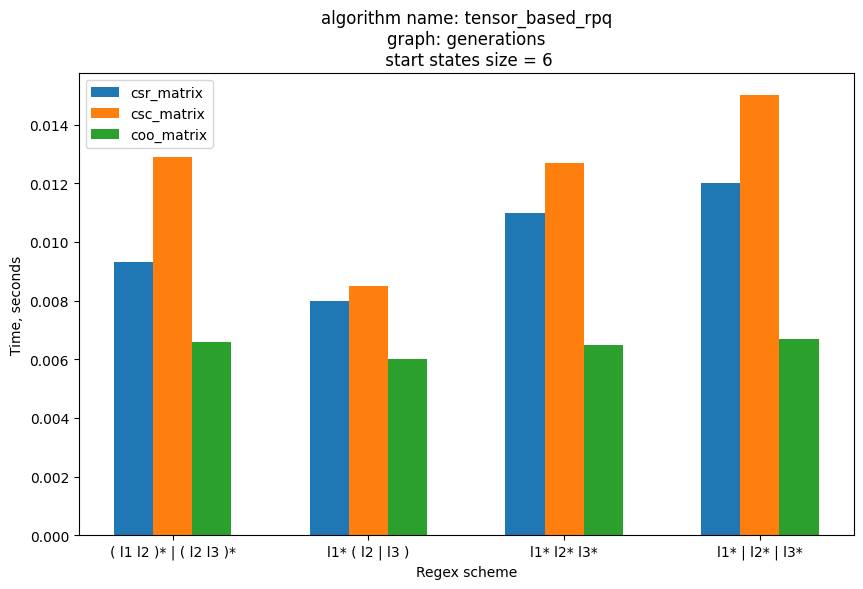

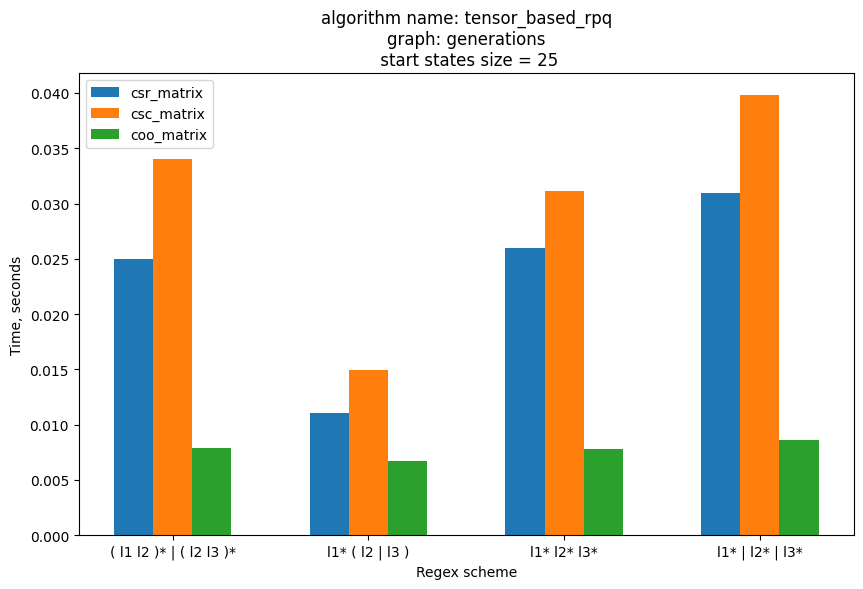

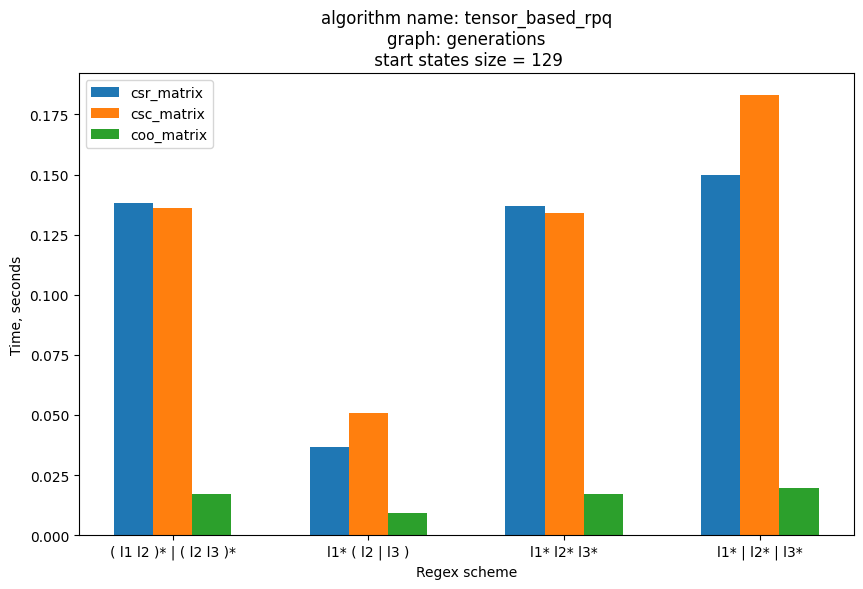

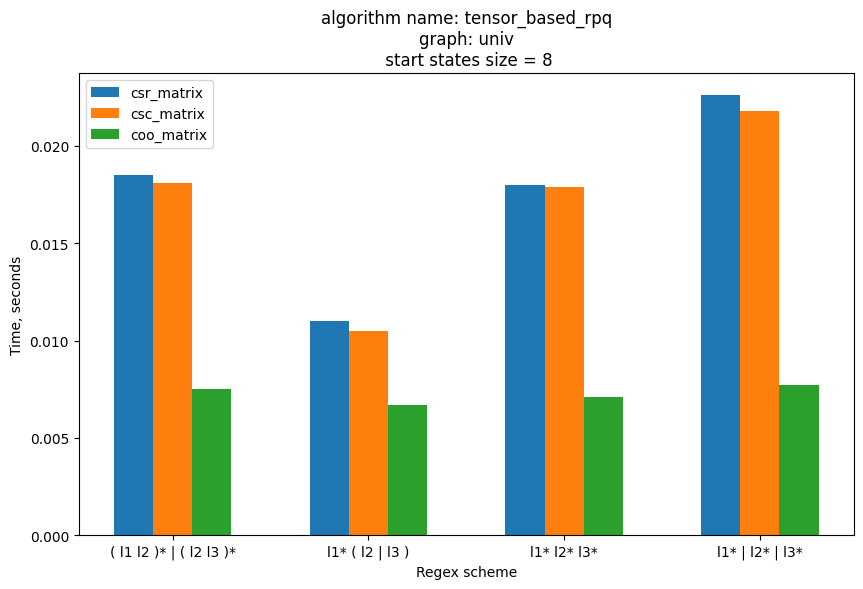

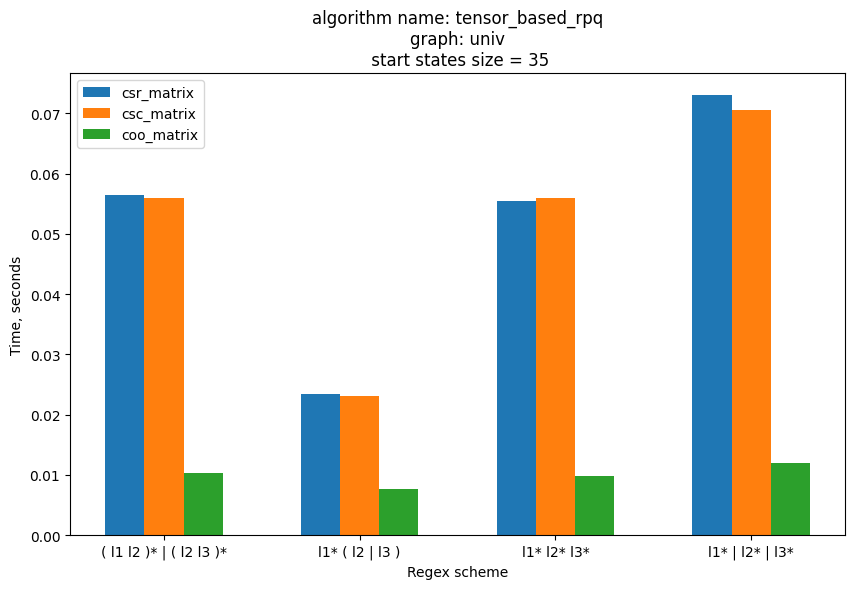

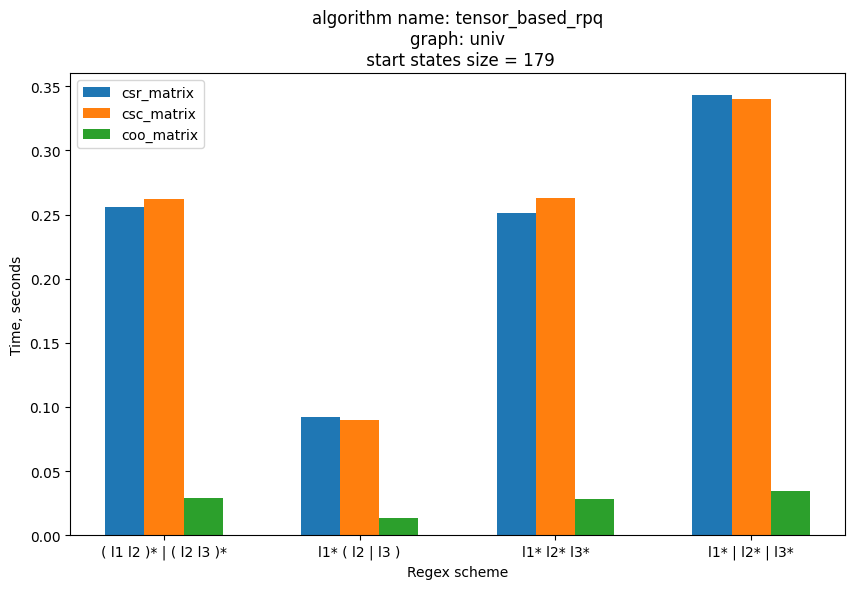

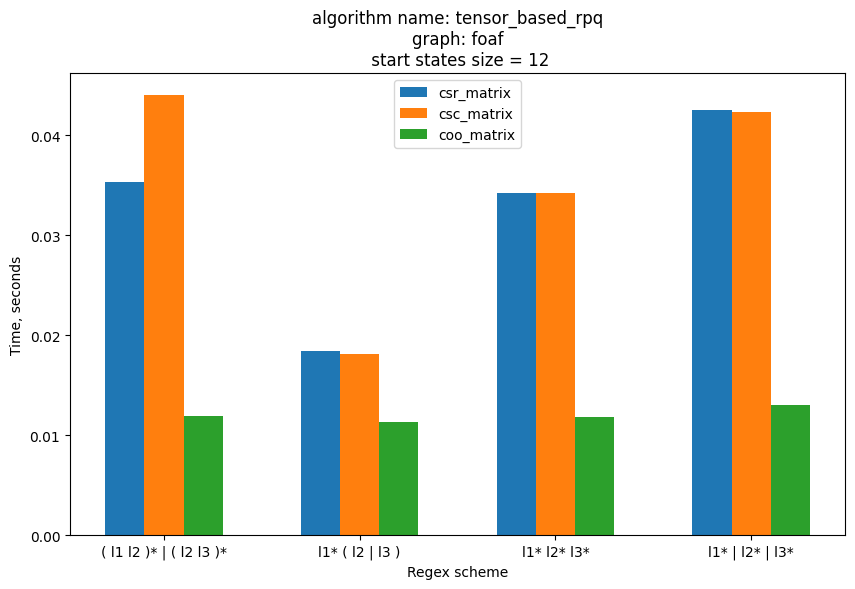

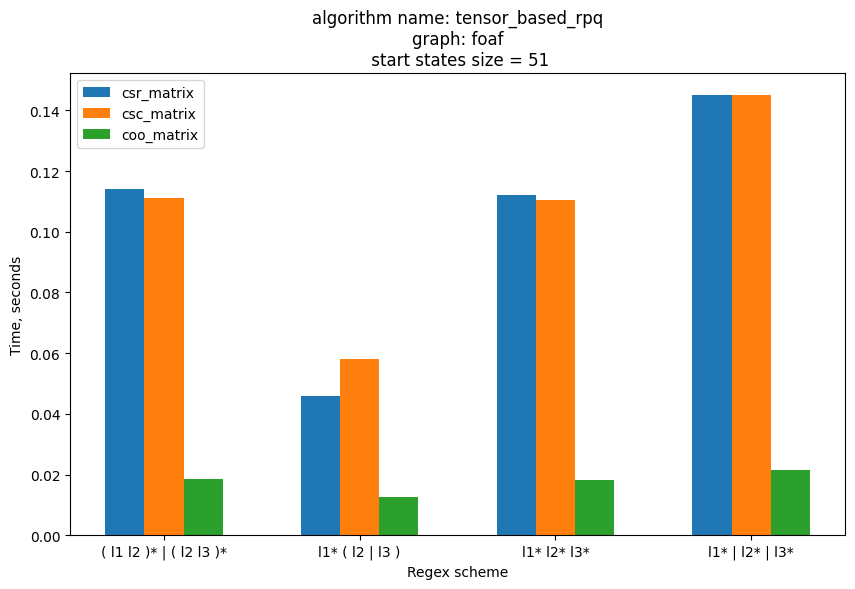

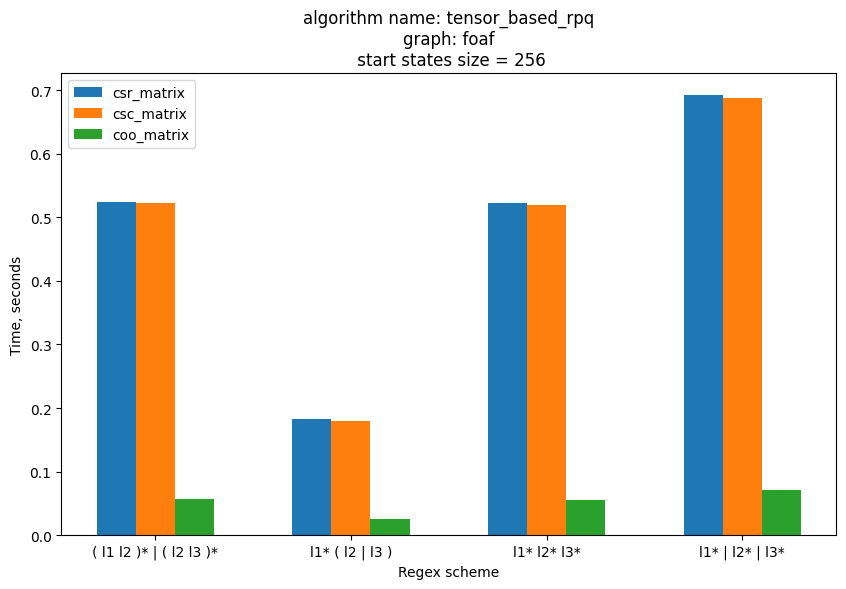

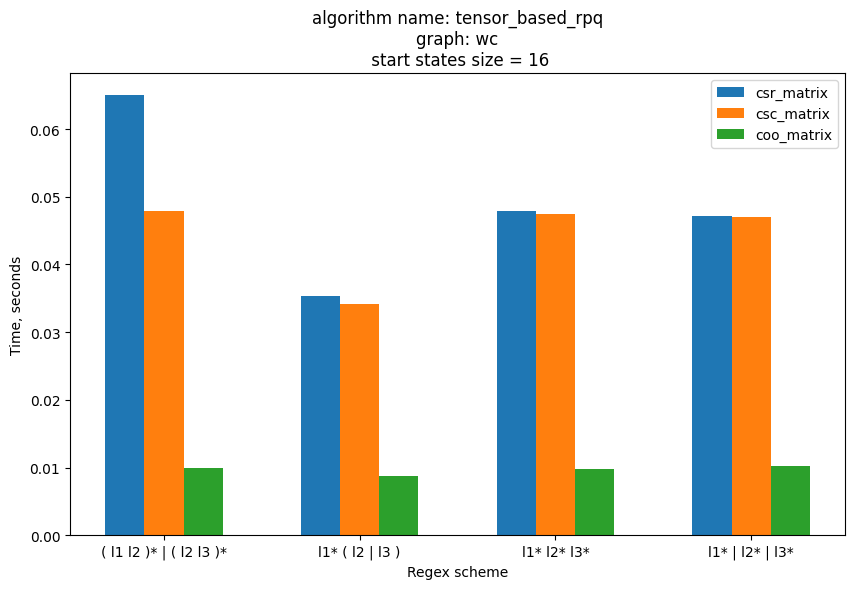

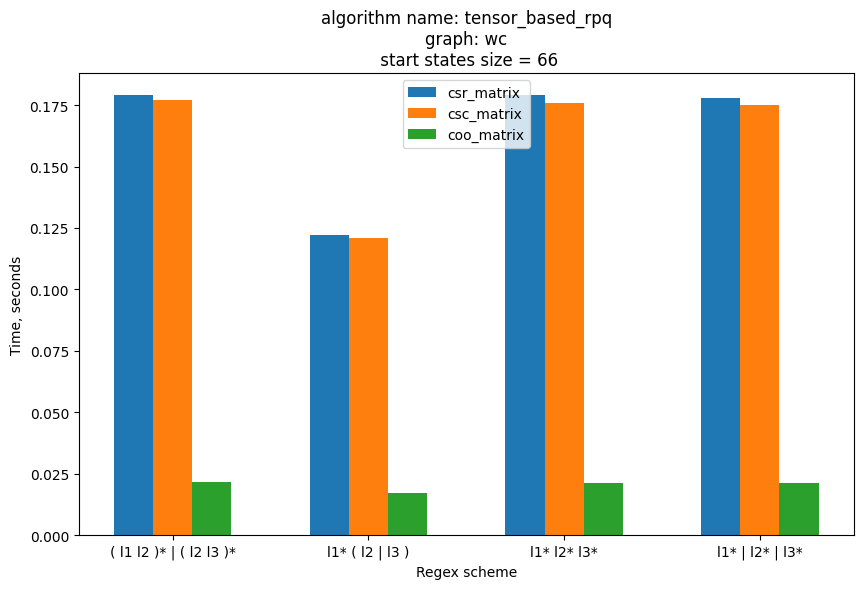

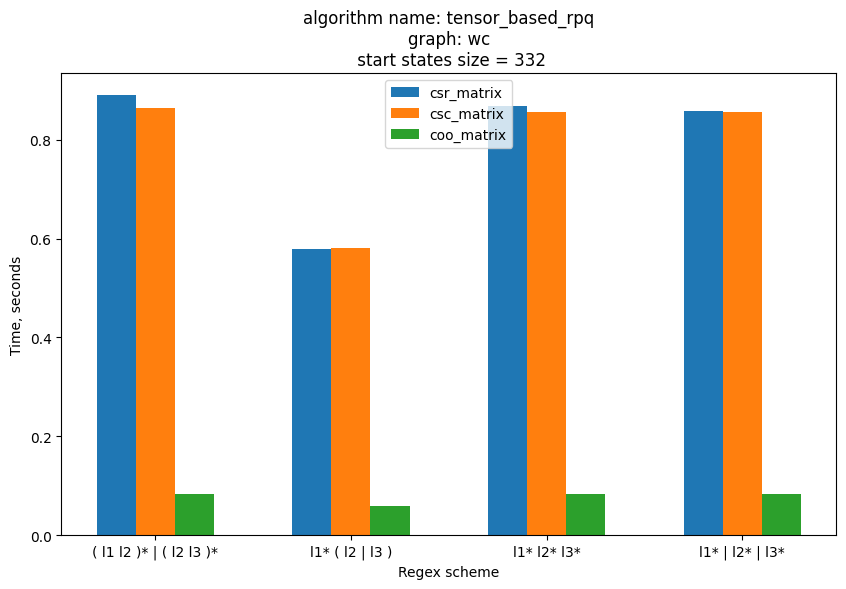

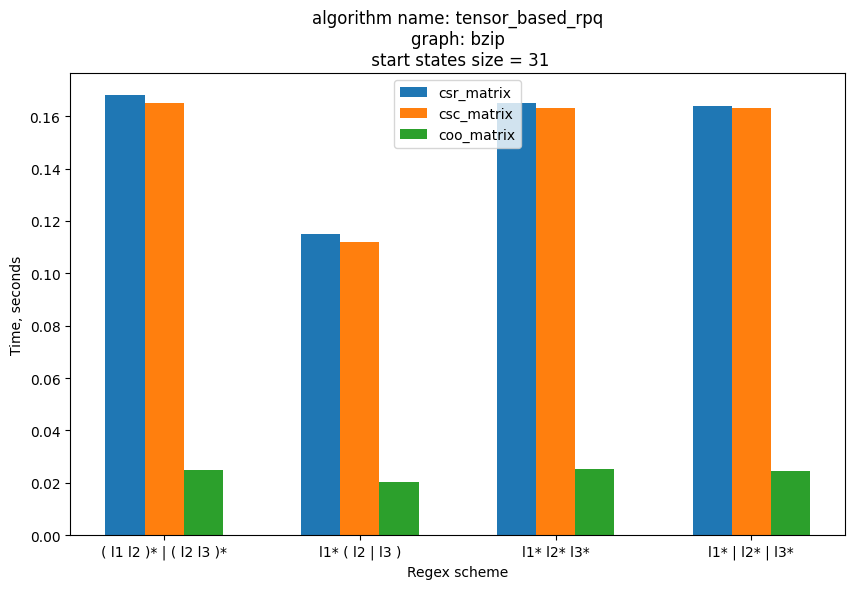

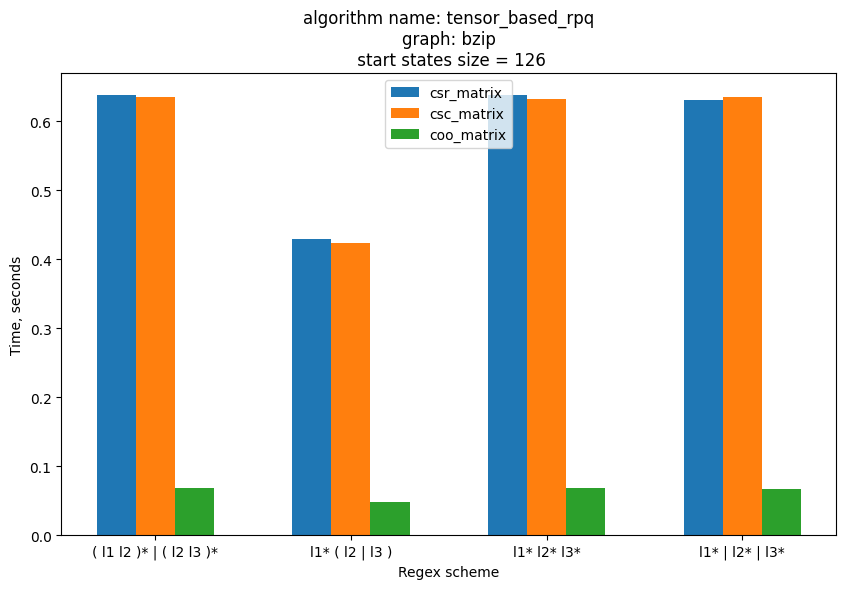

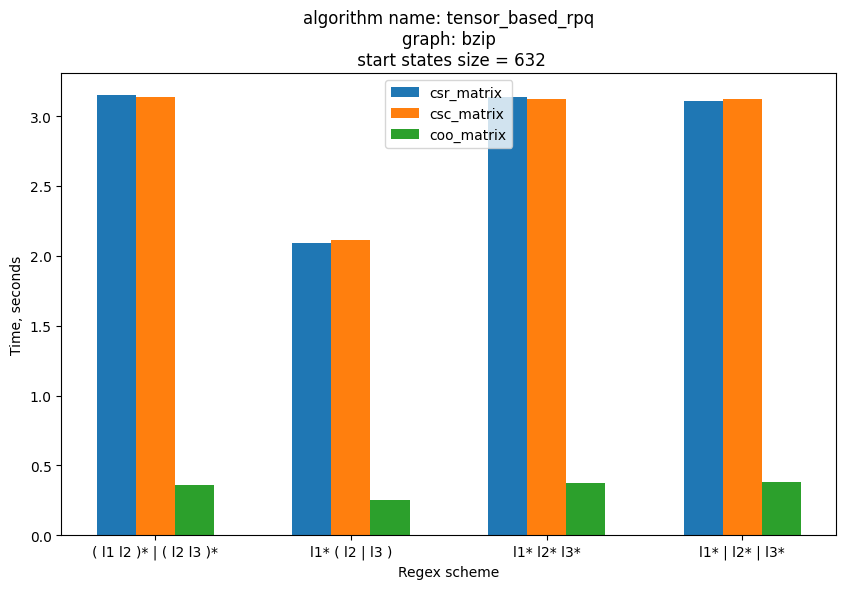

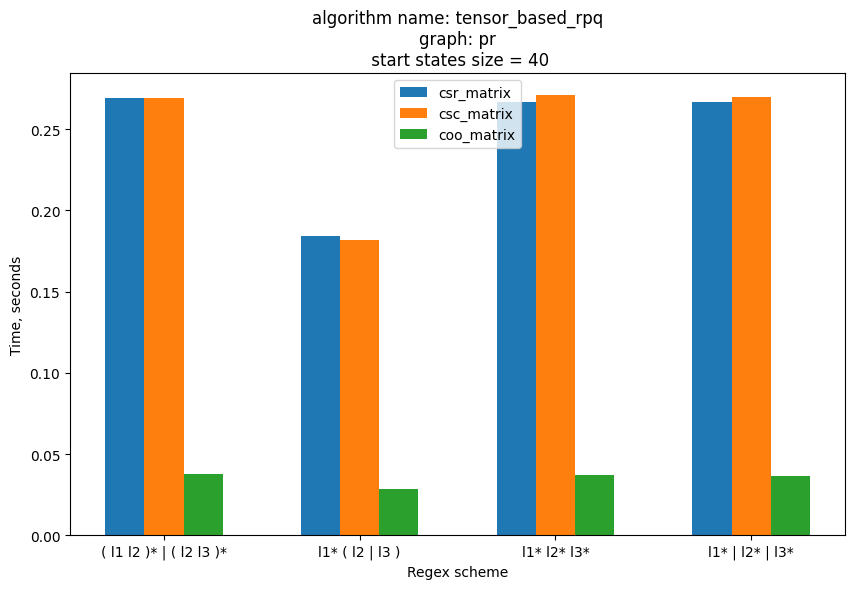

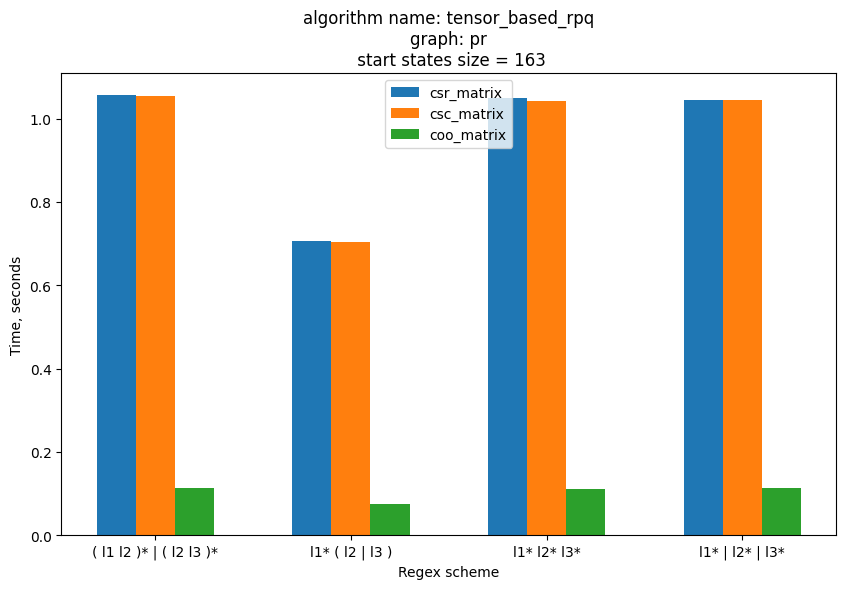

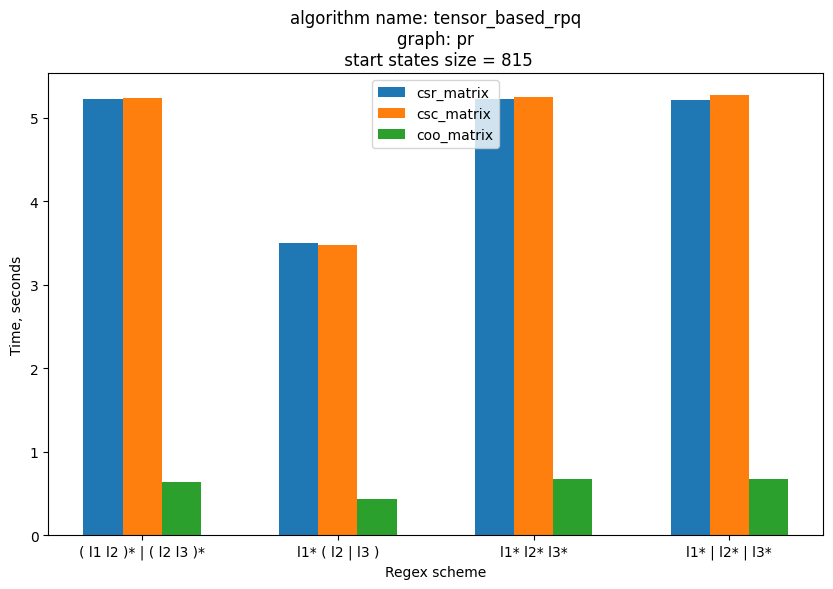

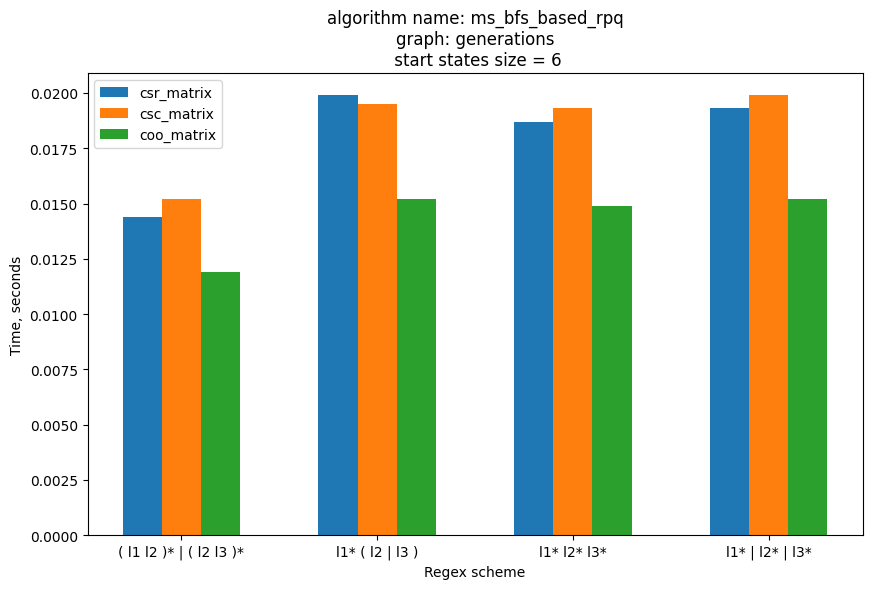

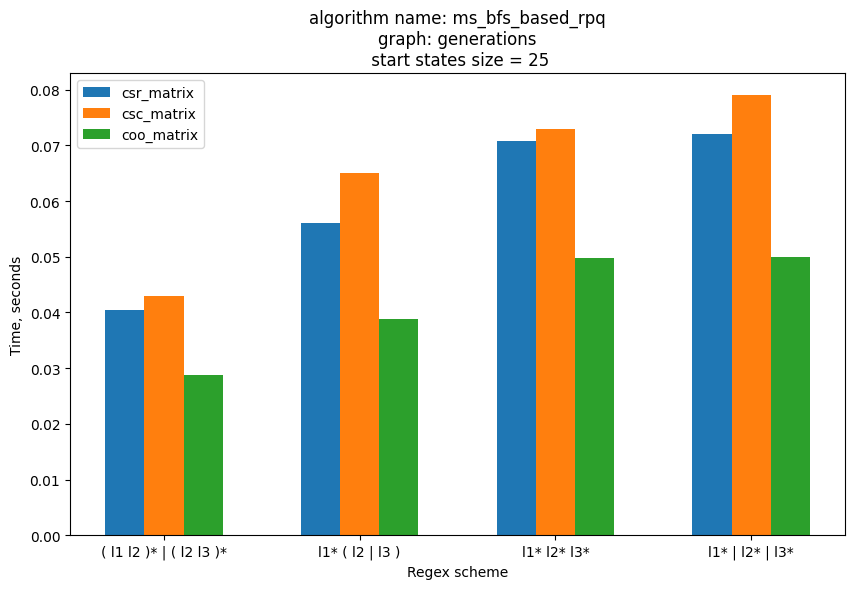

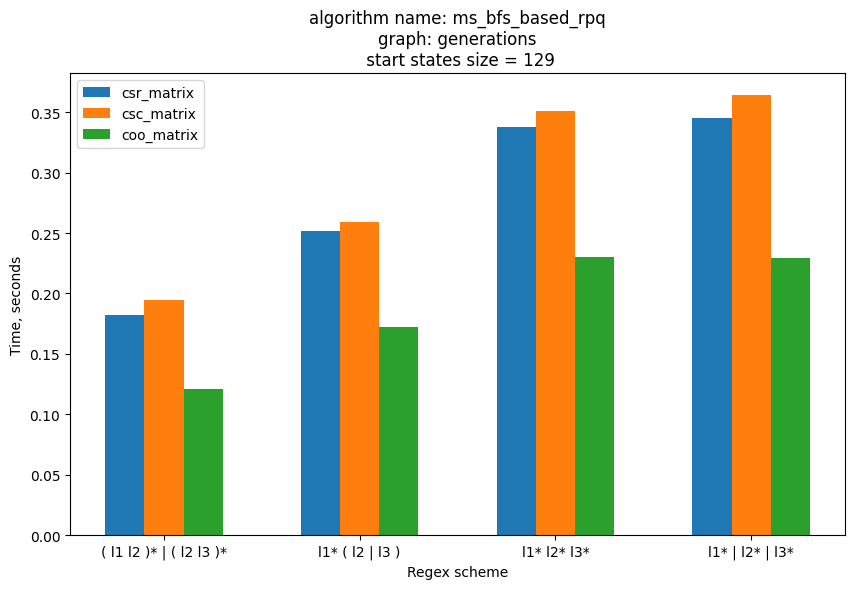

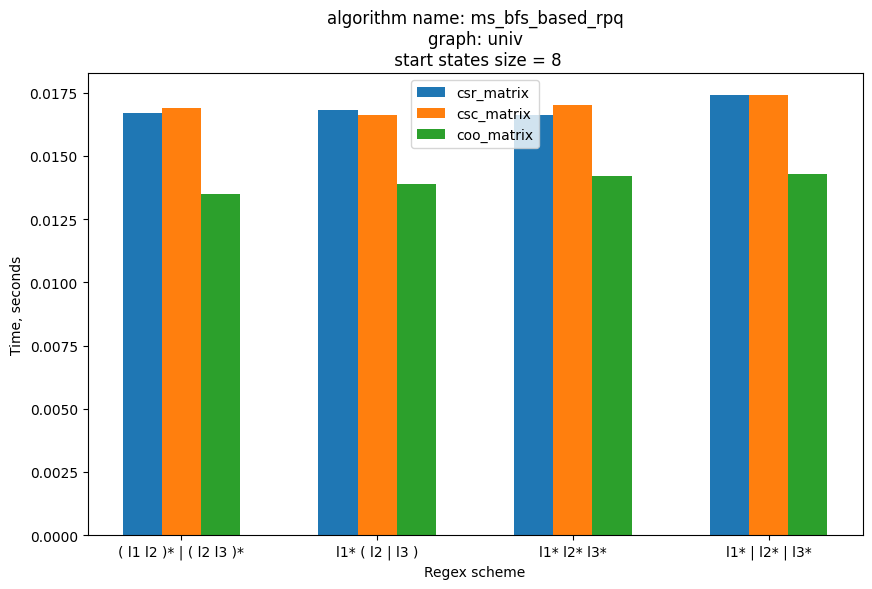

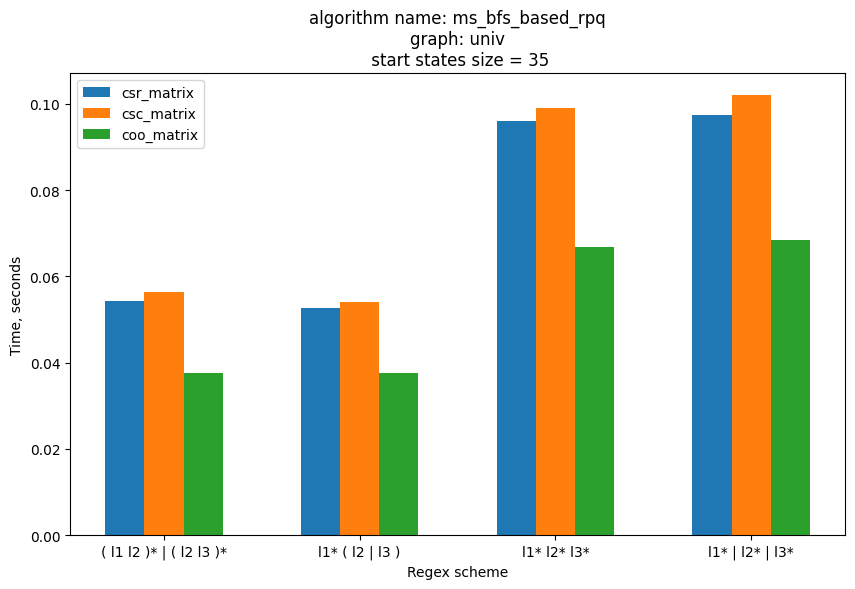

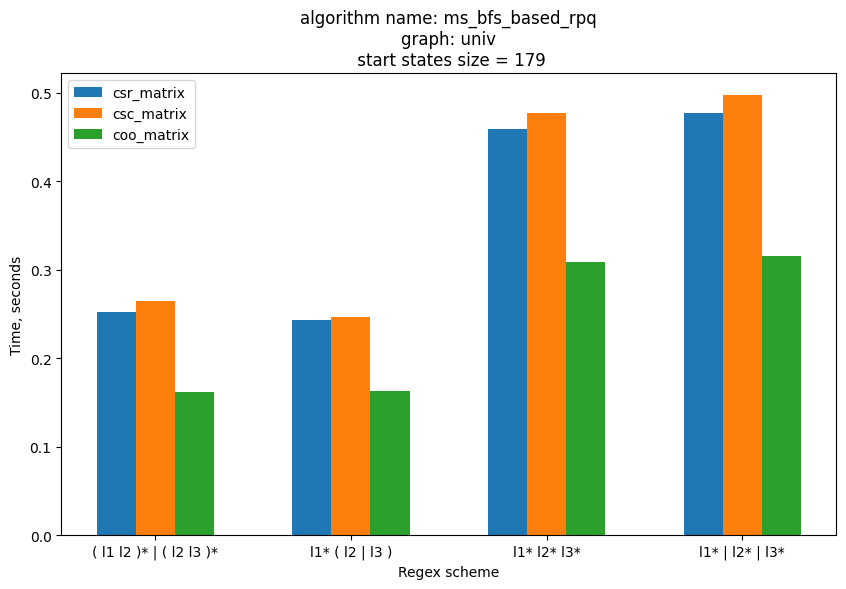

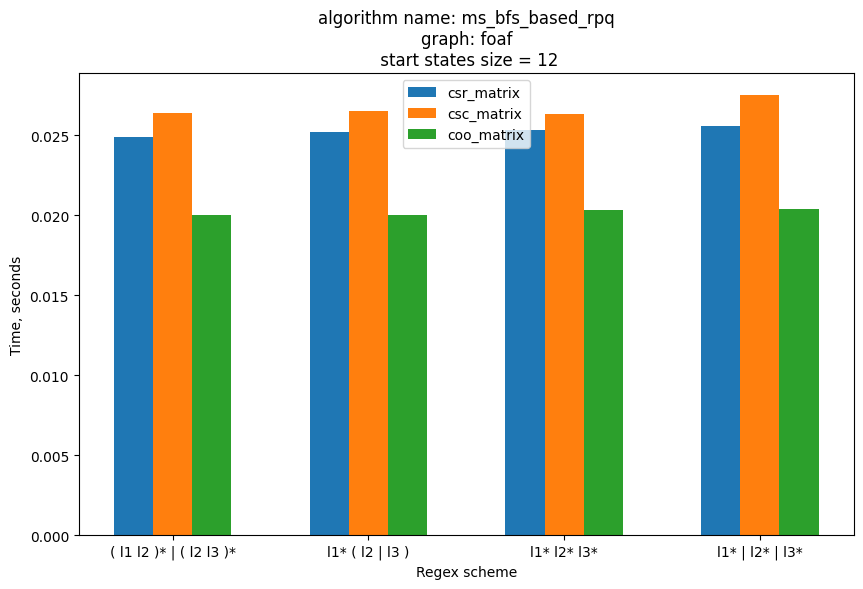

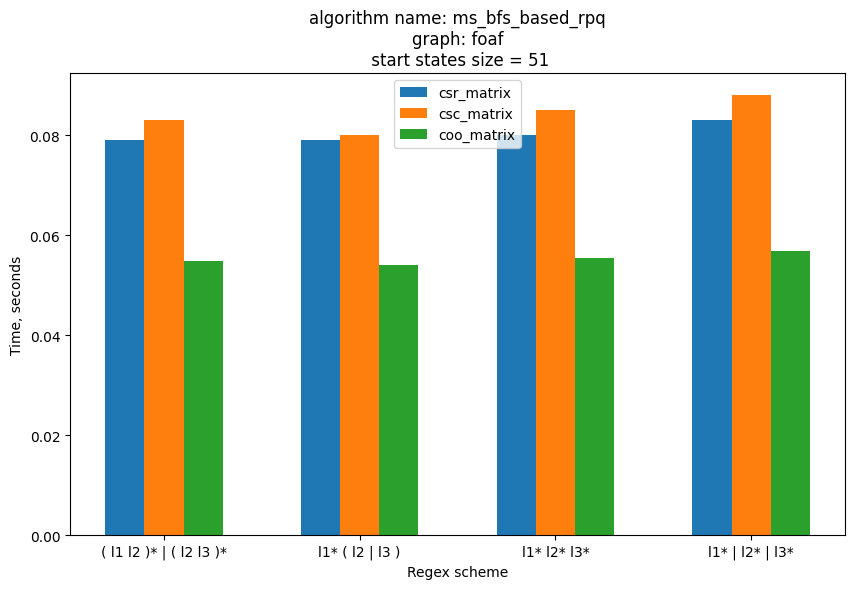

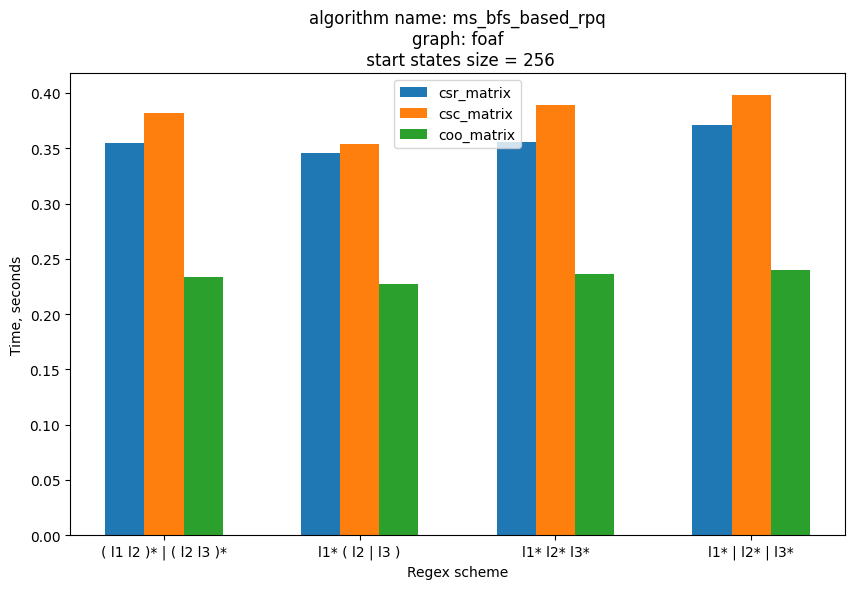

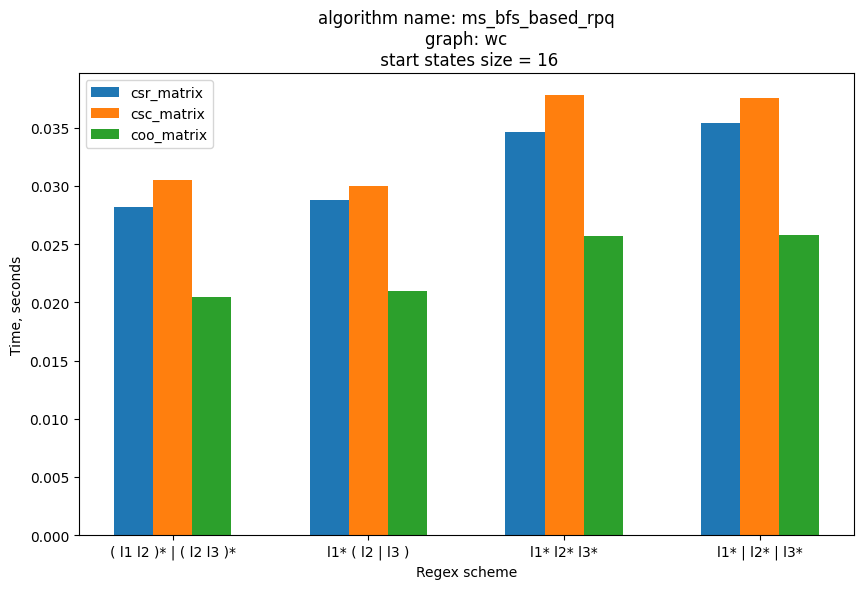

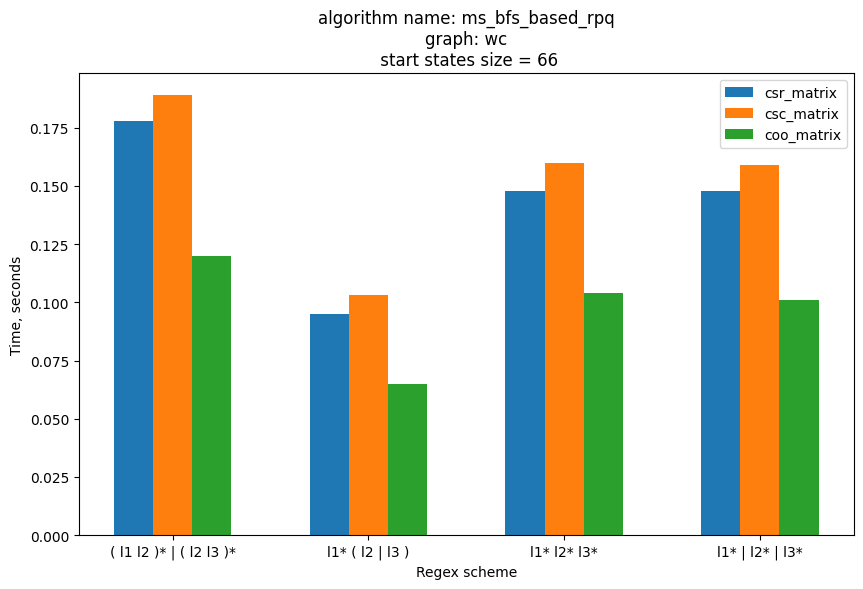

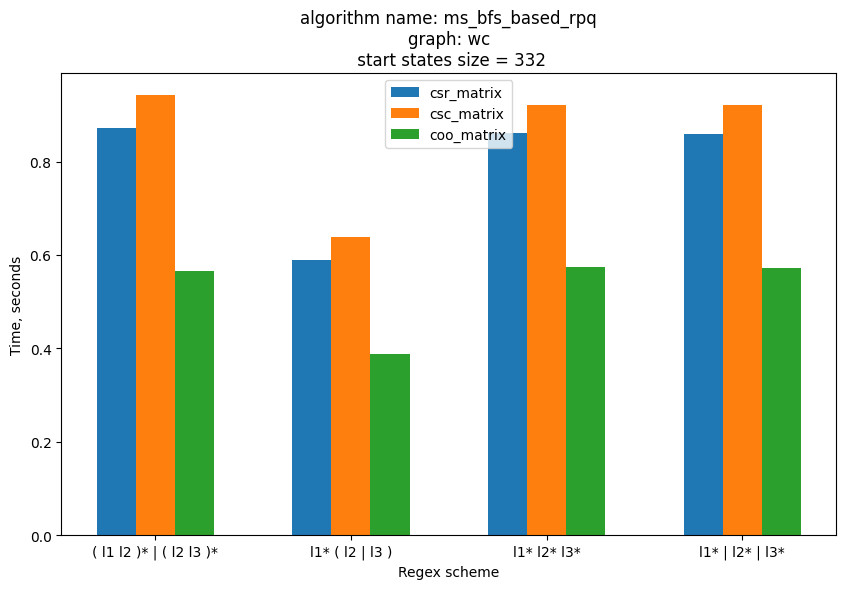

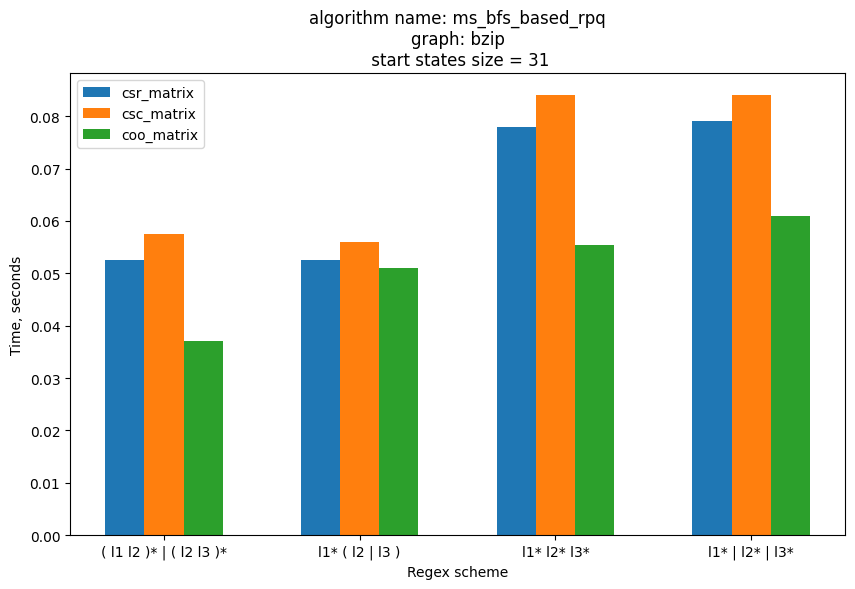

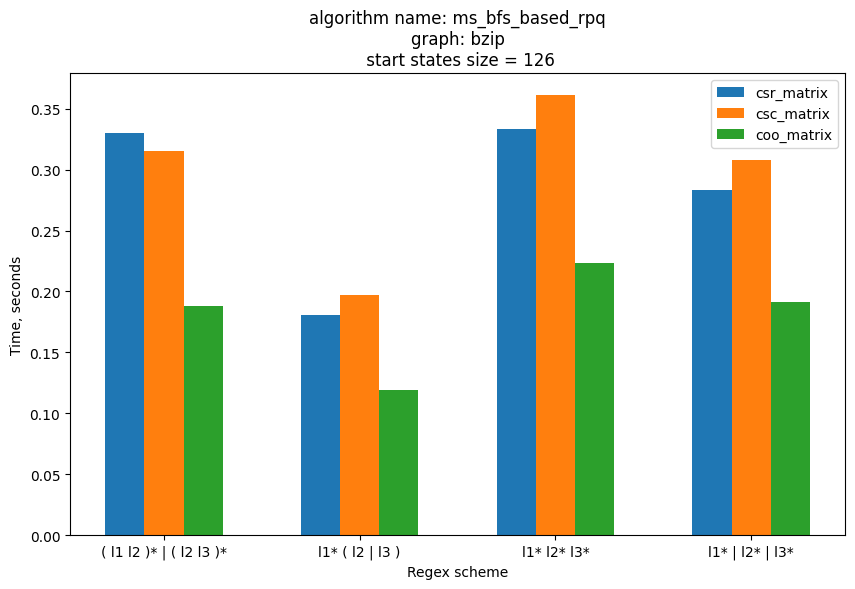

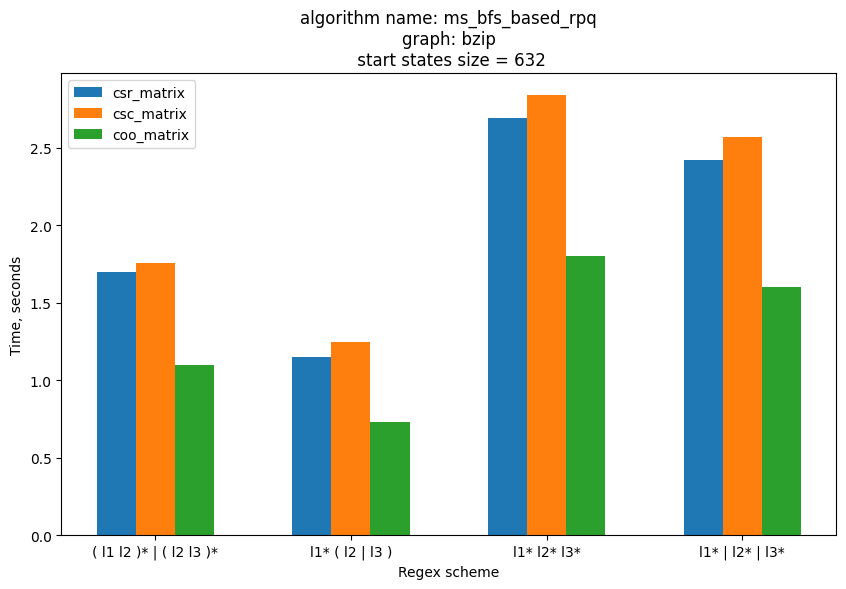

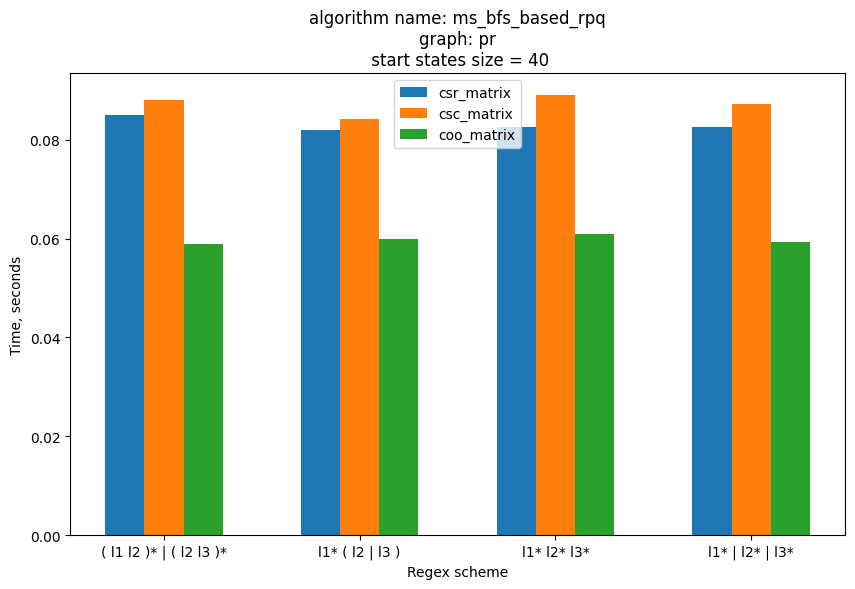

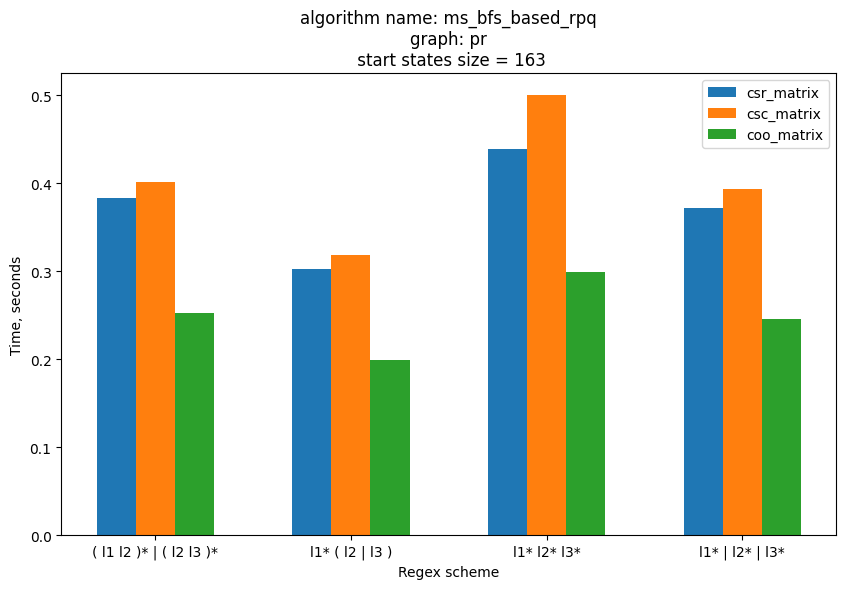

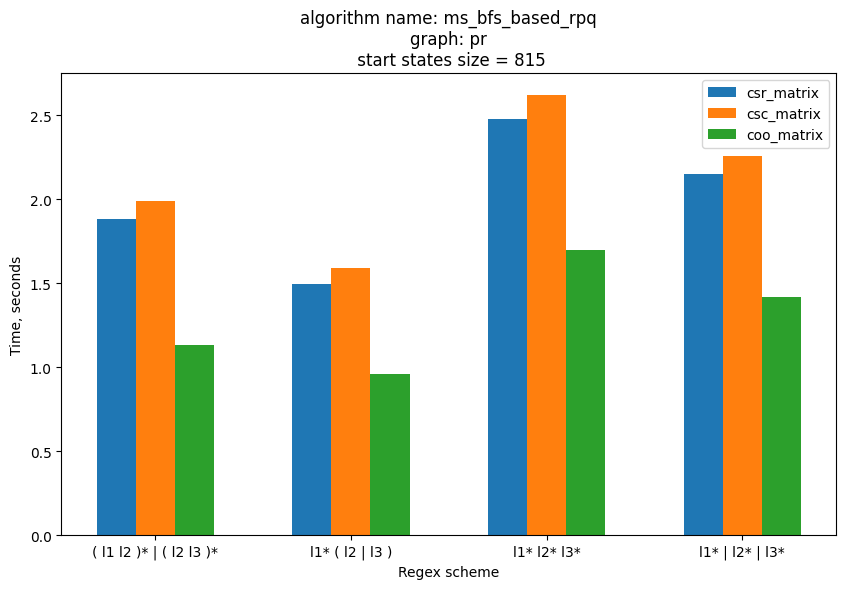

In [10]:
def plot_rpq_results(results):
    grouped_data = defaultdict(lambda: defaultdict(list))

    for result in results:
        key = (result.algorithm_name, result.graph_name, result.start_nodes_number)
        grouped_data[key][result.regex_scheme].append(result)

    for (
        algorithm_name,
        graph_name,
        start_nodes_number,
    ), regex_data in grouped_data.items():
        regex_schemes = sorted(regex_data.keys())

        x = np.arange(len(regex_schemes))
        width = 0.2
        fig, ax = plt.subplots(figsize=(10, 6))

        for i, matrix_type in enumerate(SPARSE_MATRICES_TYPES_NAMES):
            times = []
            for regex in regex_schemes:
                found = False
                for res in regex_data[regex]:
                    if res.sparse_matrix_type == matrix_type:
                        times.append(float(res.mean_time))
                        found = True
                        break
                if not found:
                    times.append(0.0)
            ax.bar(x + i * width, times, width, label=matrix_type)

        ax.set_xlabel("Regex scheme")
        ax.set_ylabel("Time, seconds")
        ax.set_title(
            f"algorithm name: {algorithm_name}\ngraph: {graph_name}\n start states size = {start_nodes_number}"
        )
        ax.set_xticks(x + width * (len(SPARSE_MATRICES_TYPES_NAMES) - 1) / 2)
        ax.set_xticklabels(regex_schemes)
        ax.legend()
        plt.show()


plot_rpq_results(results)

## 2. Размер стартового множества, начиная с которго выгоднее решать задачу для всех пар и выбирать нужные ##

В ходе эксперимента были проведены запуски `ms_bfs_based_rpq` и `tensor_based_rpq` на подготовленных ранее данных.


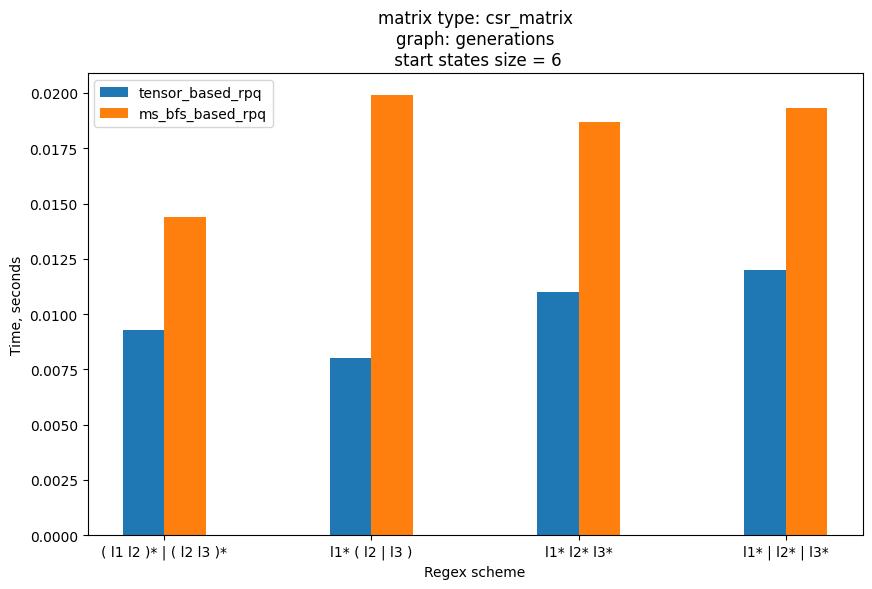

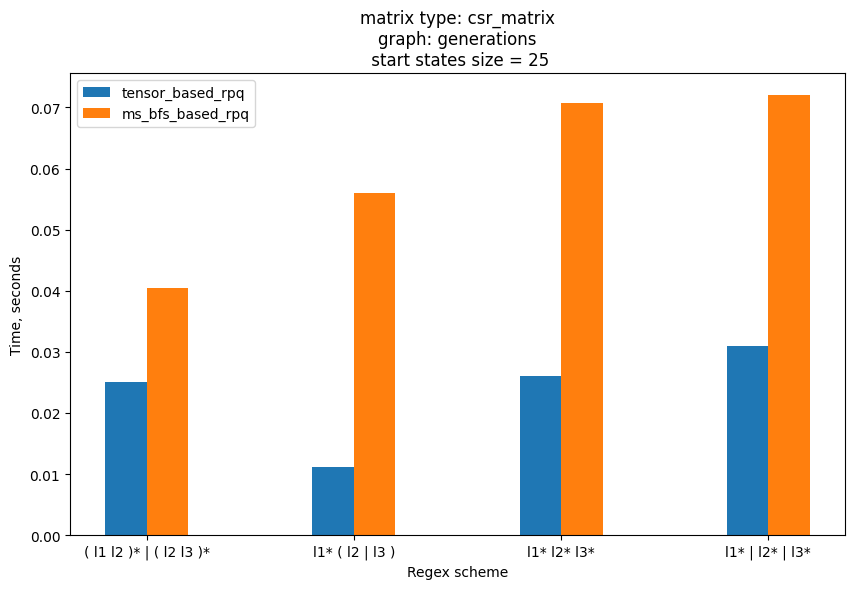

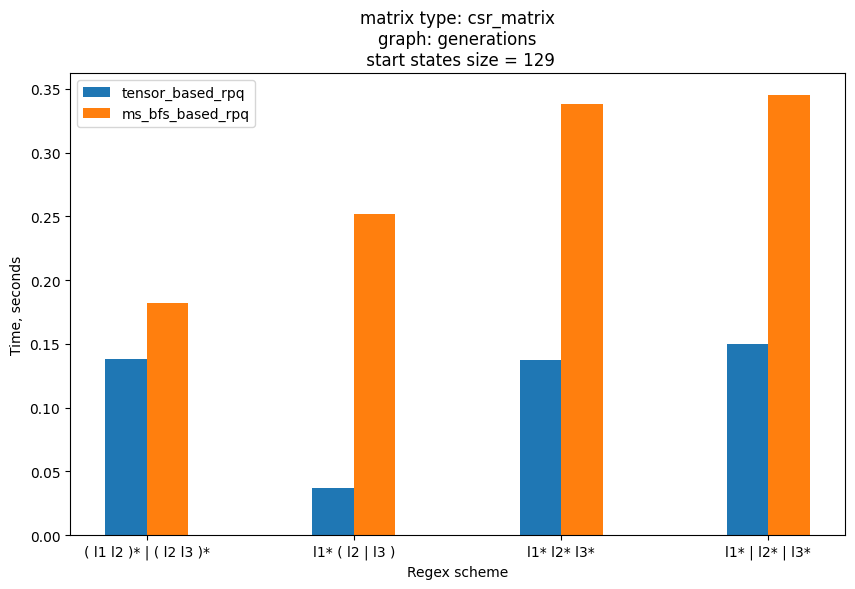

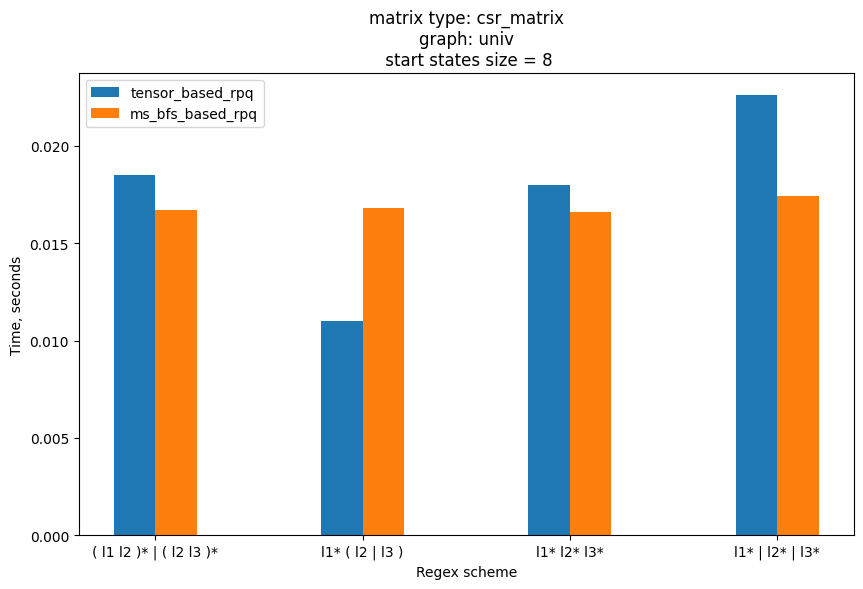

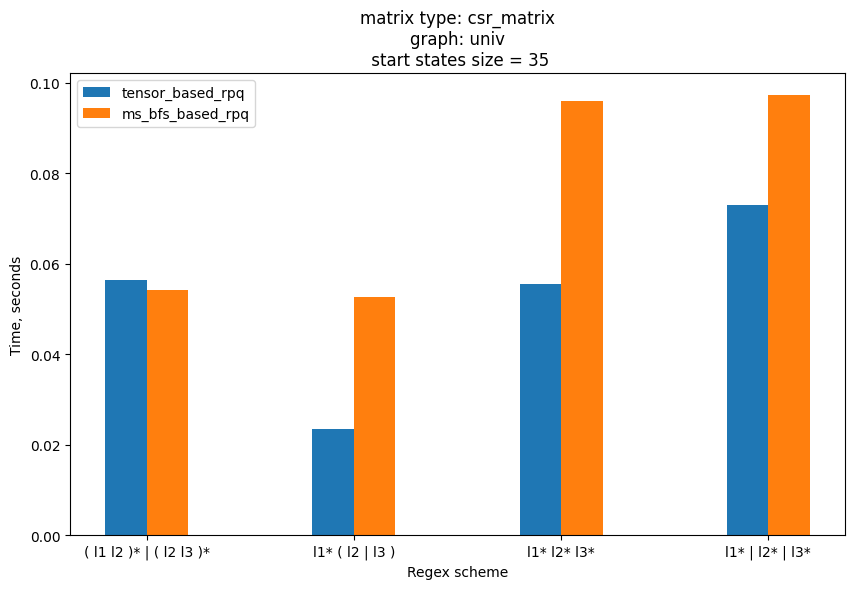

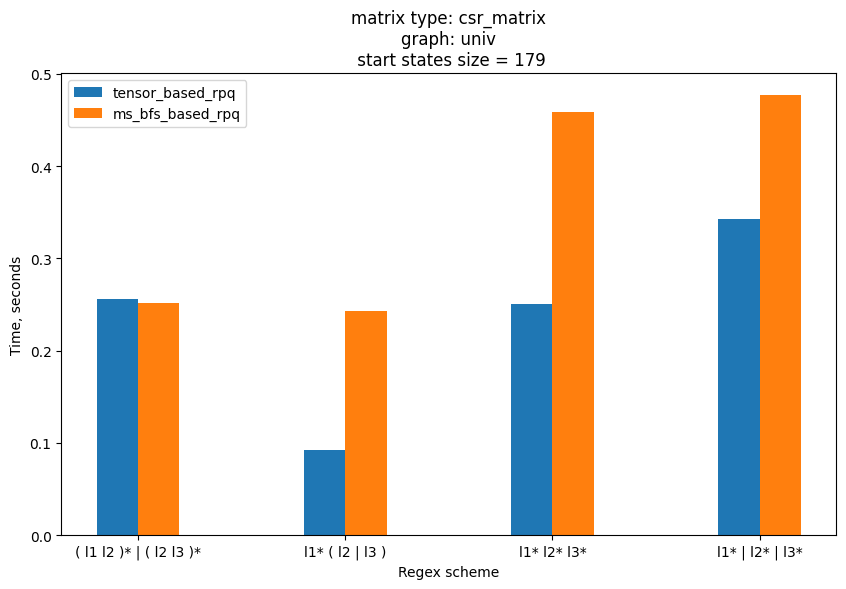

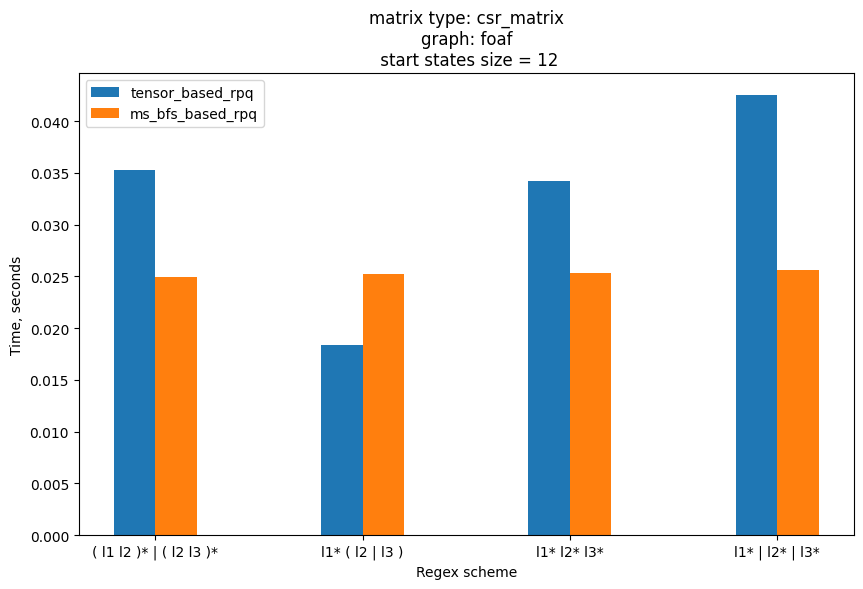

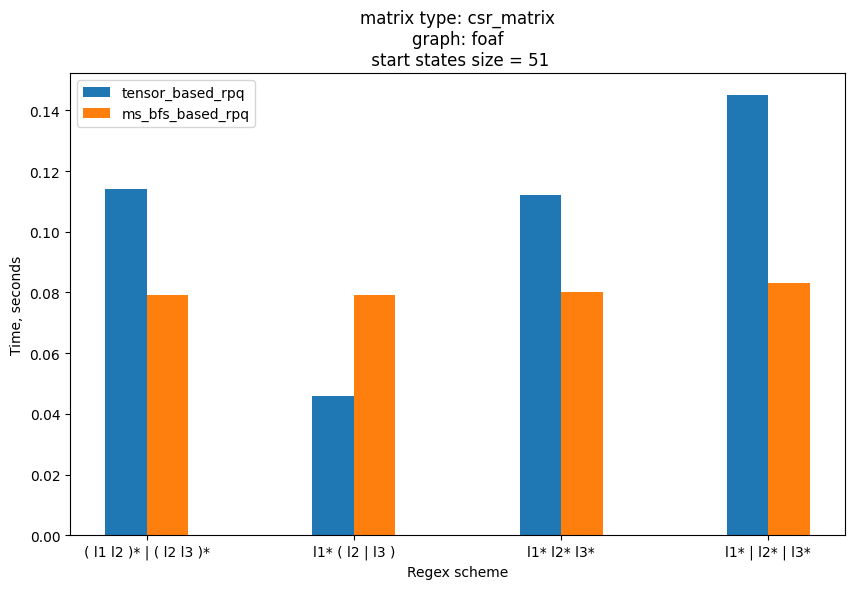

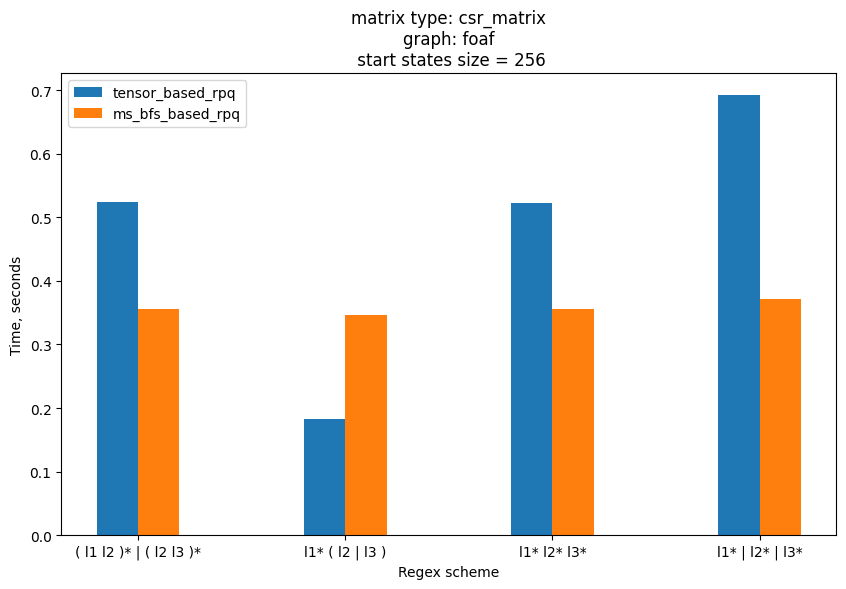

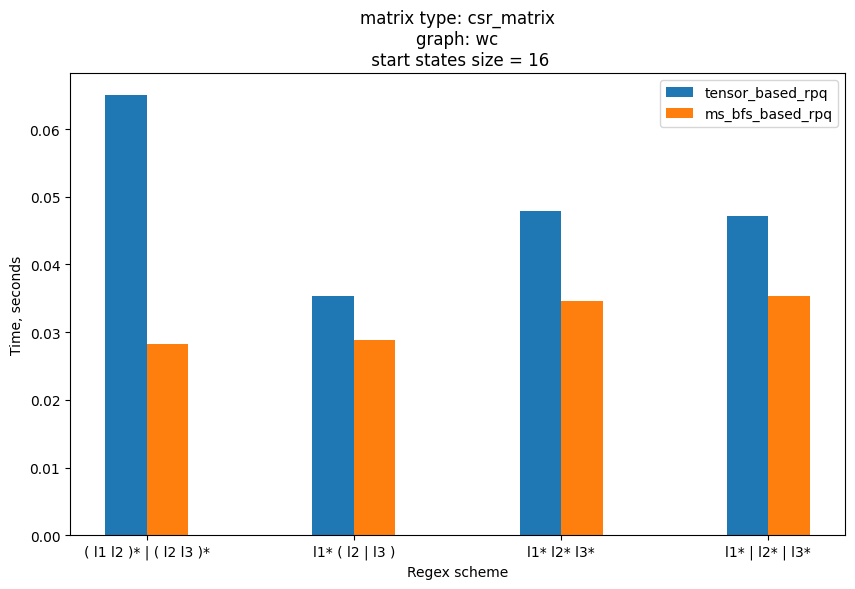

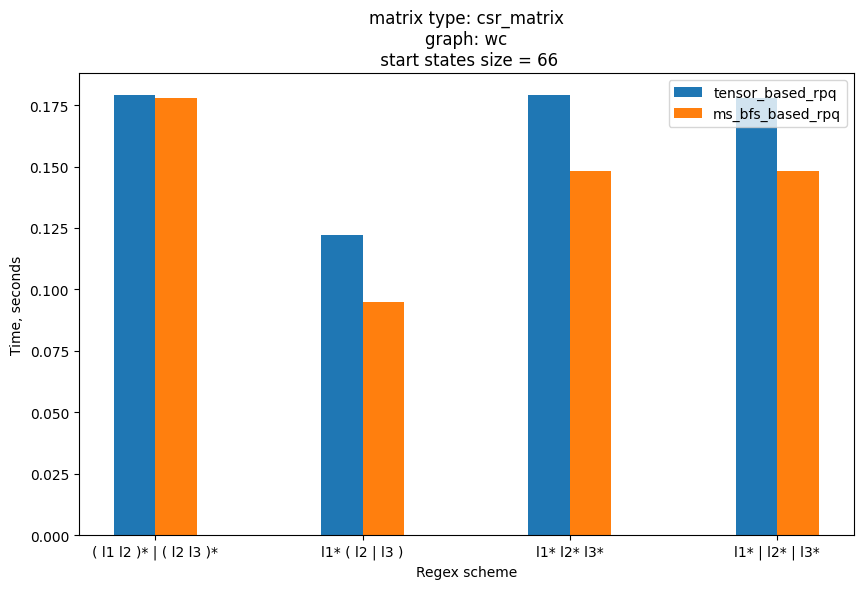

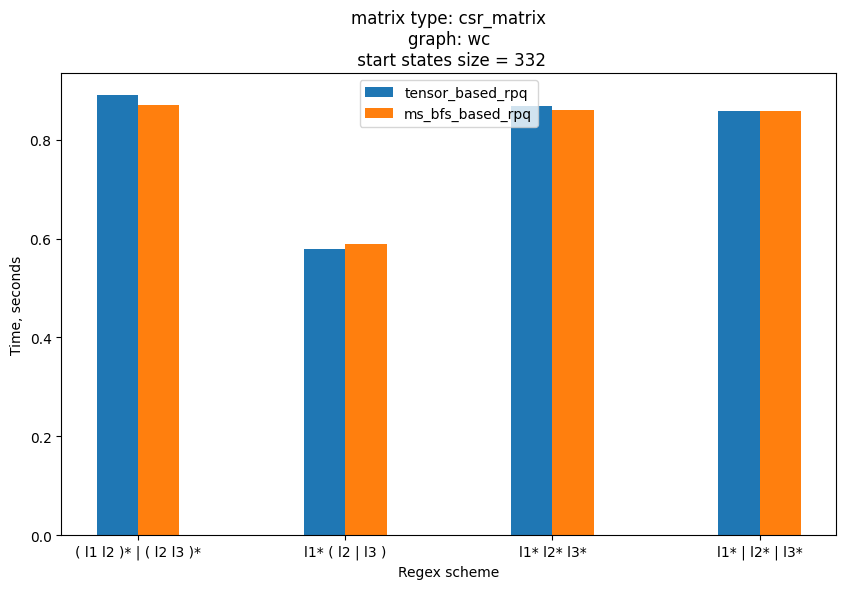

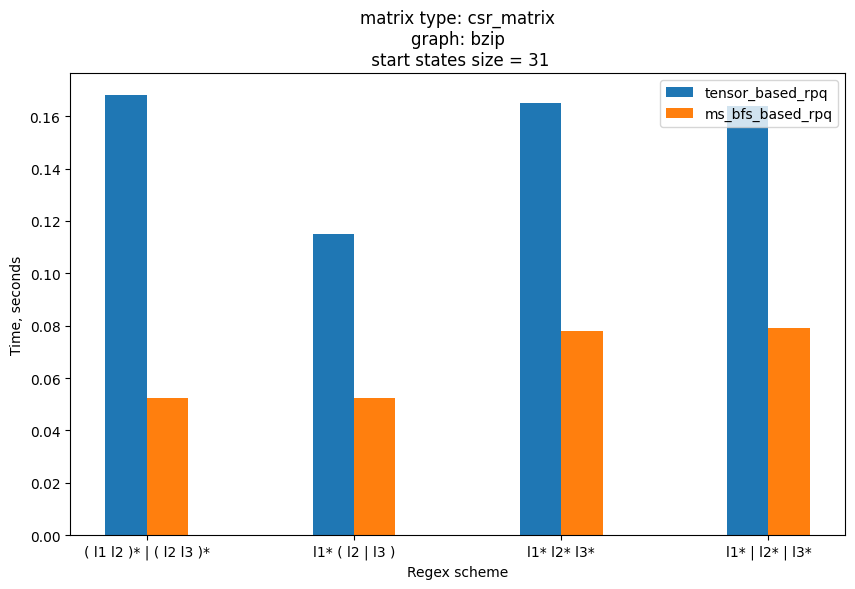

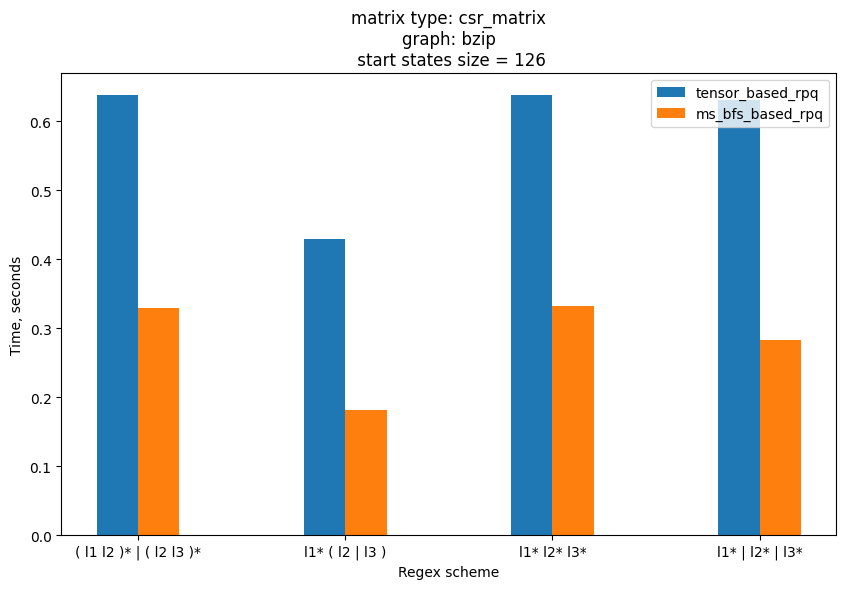

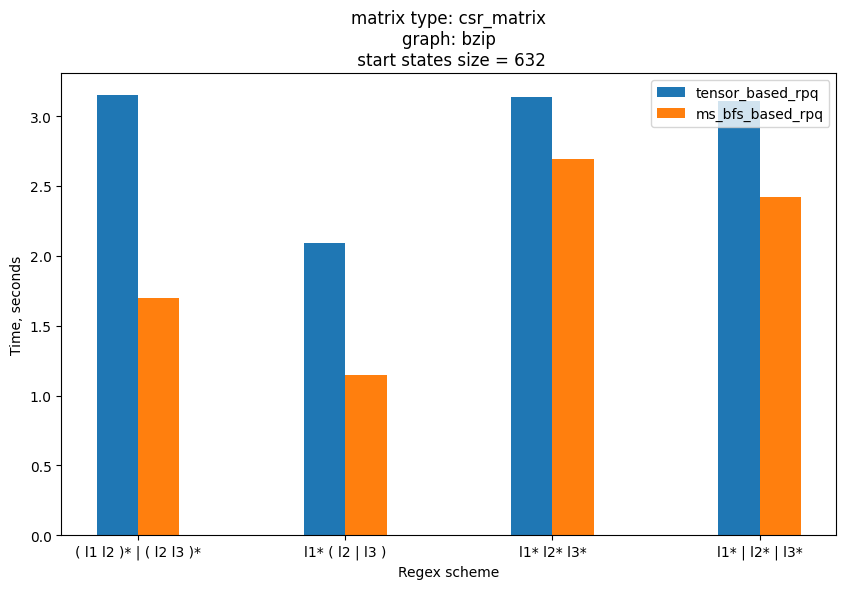

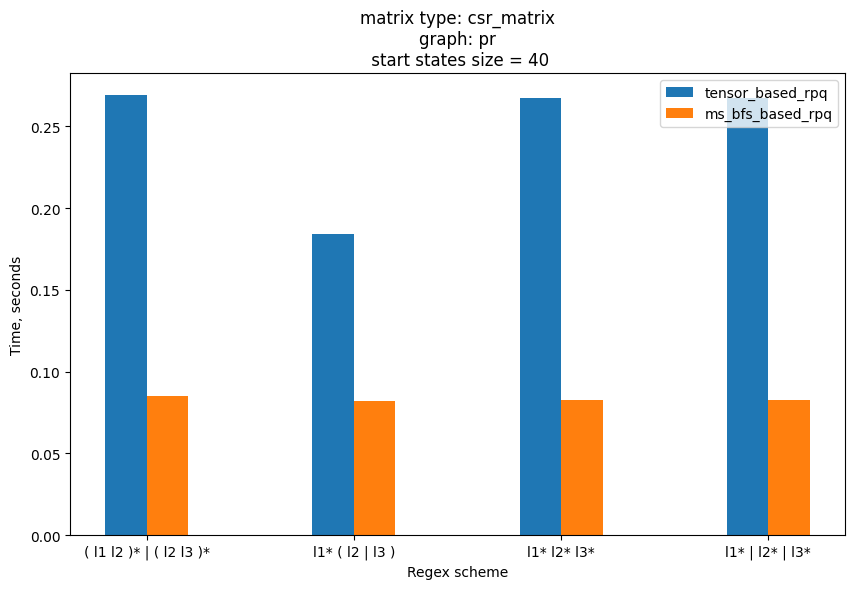

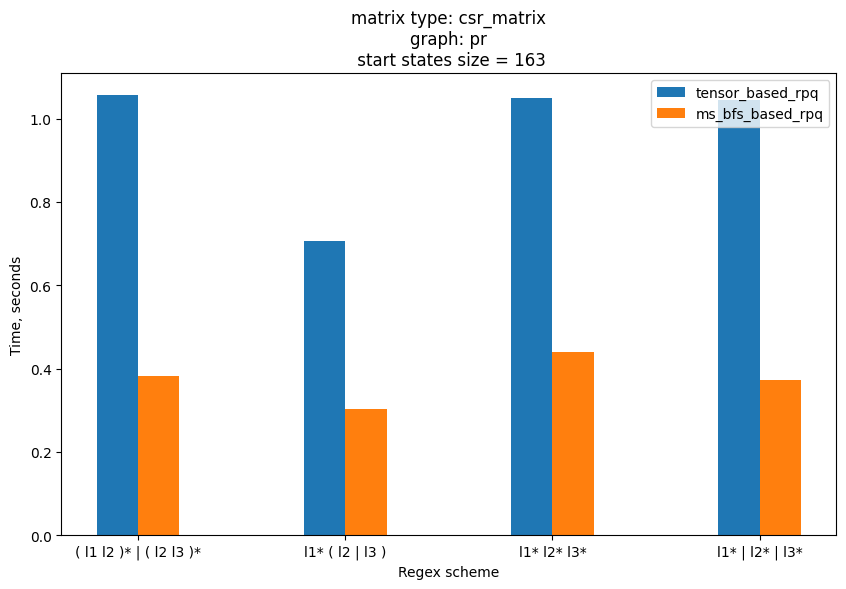

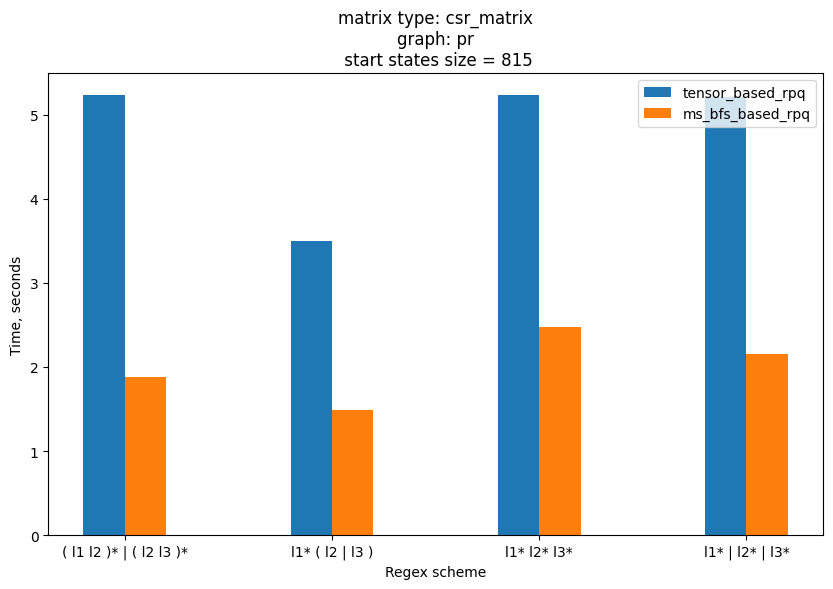

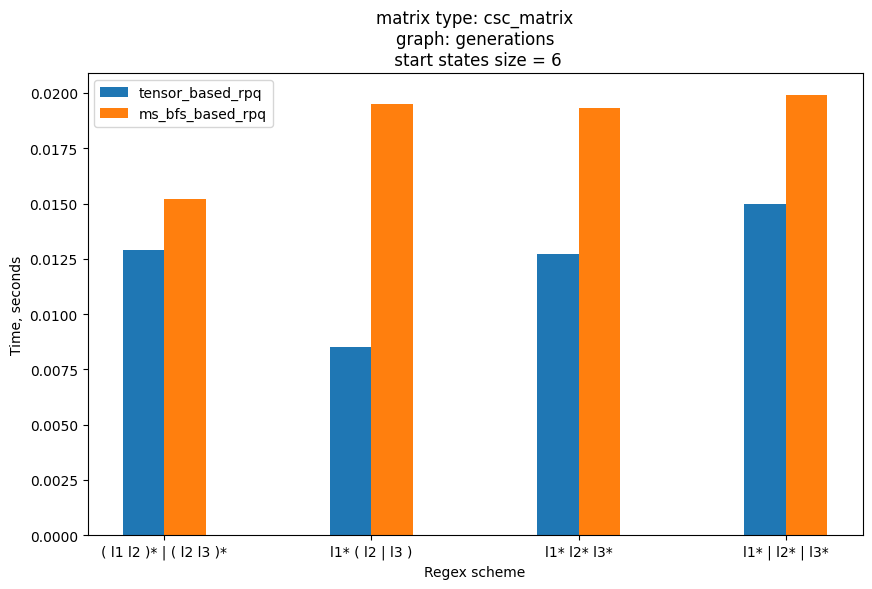

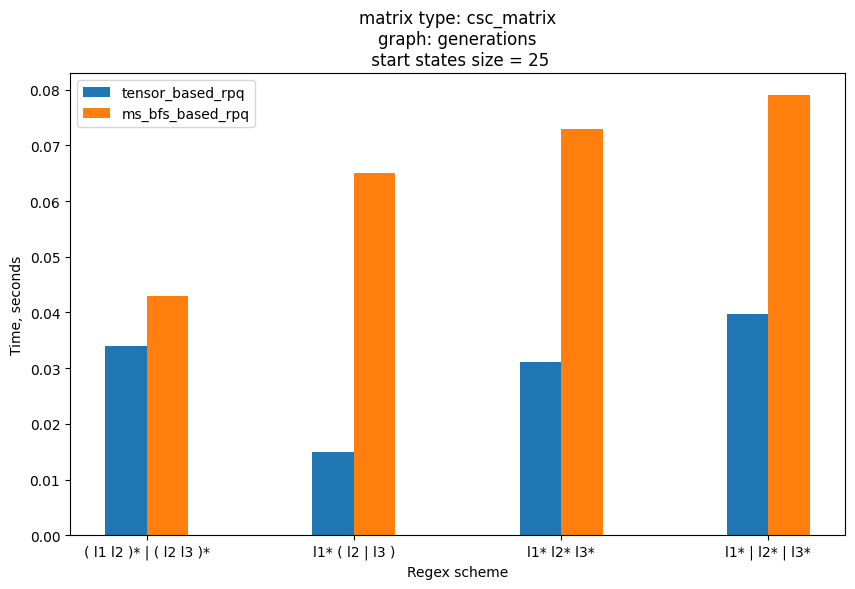

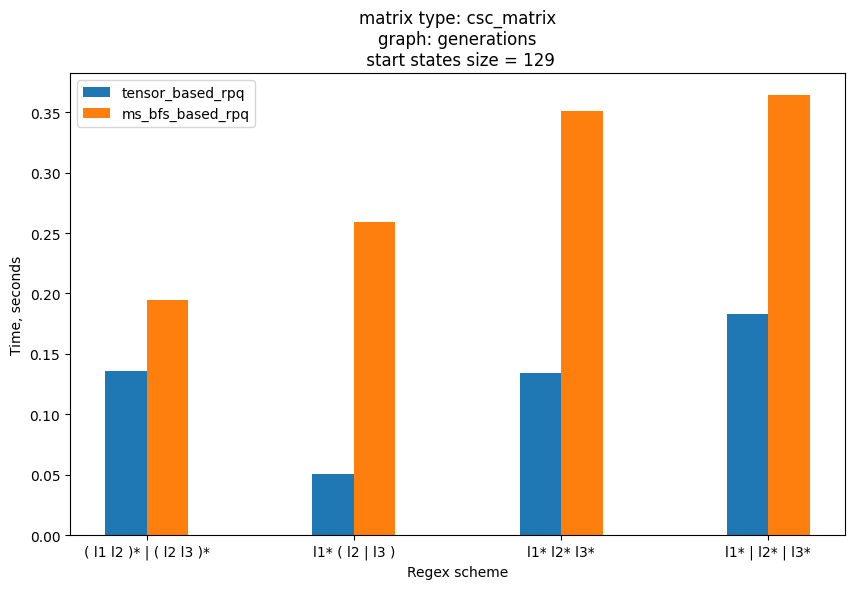

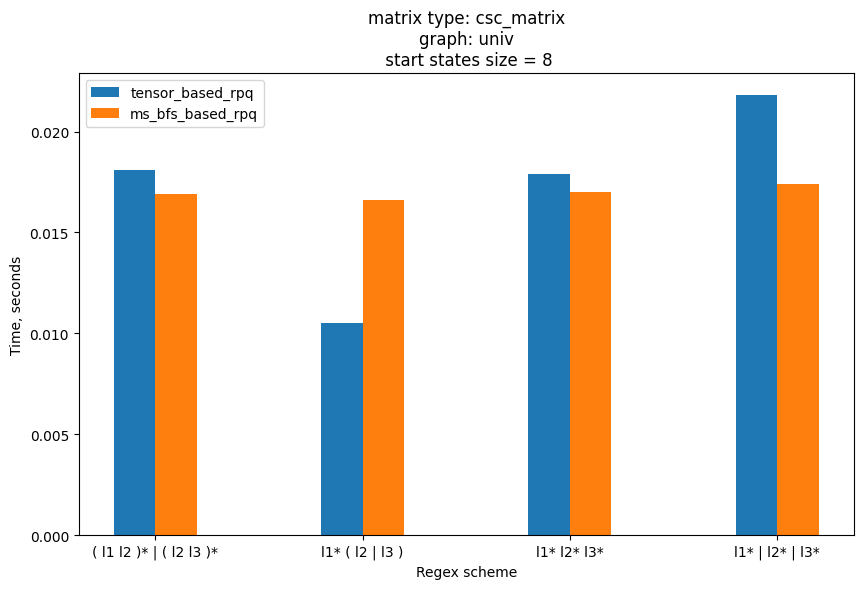

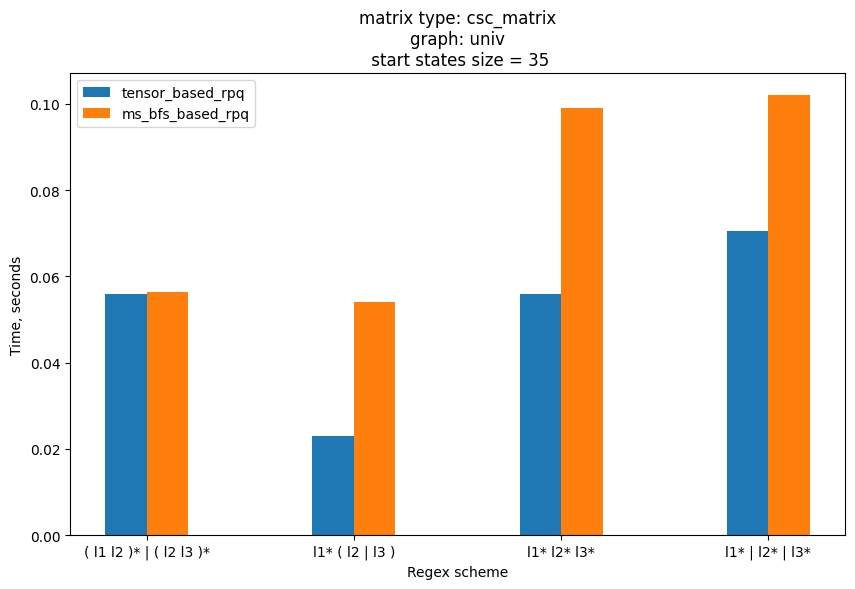

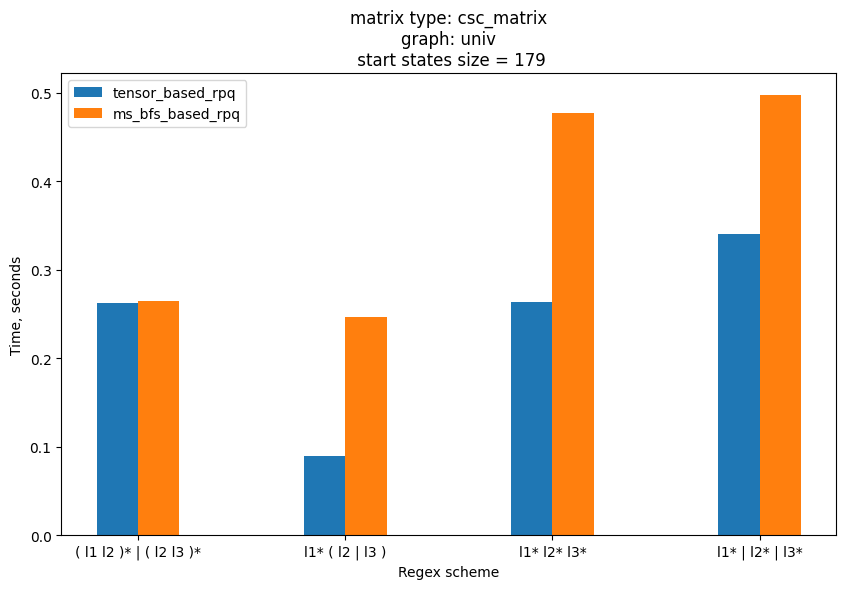

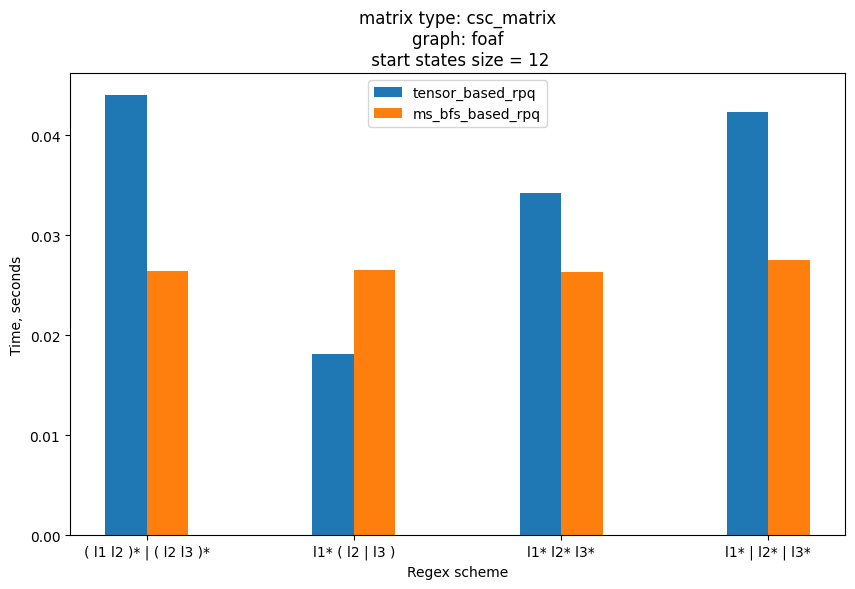

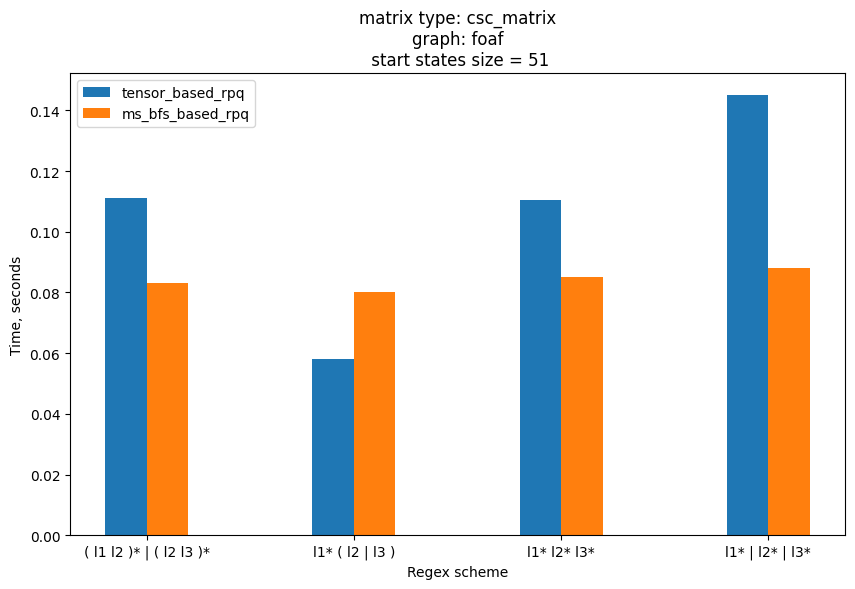

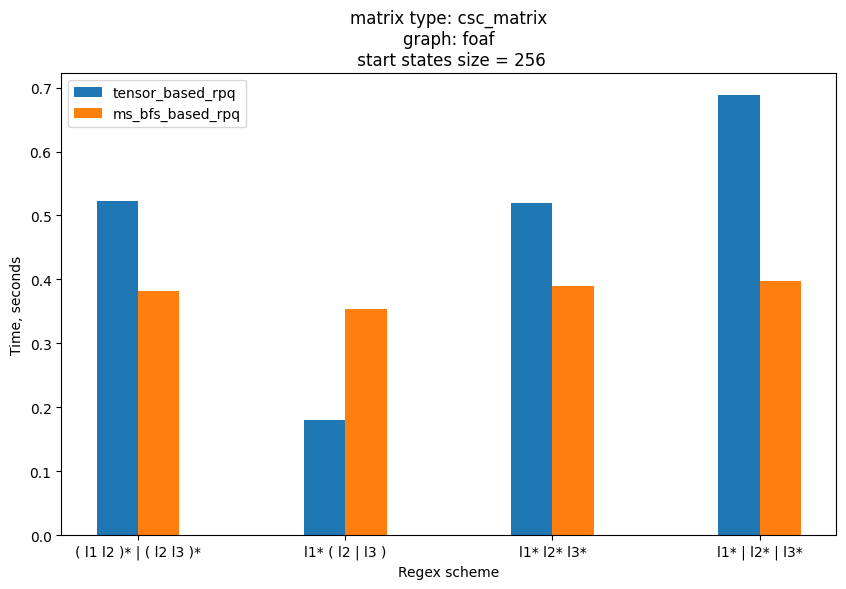

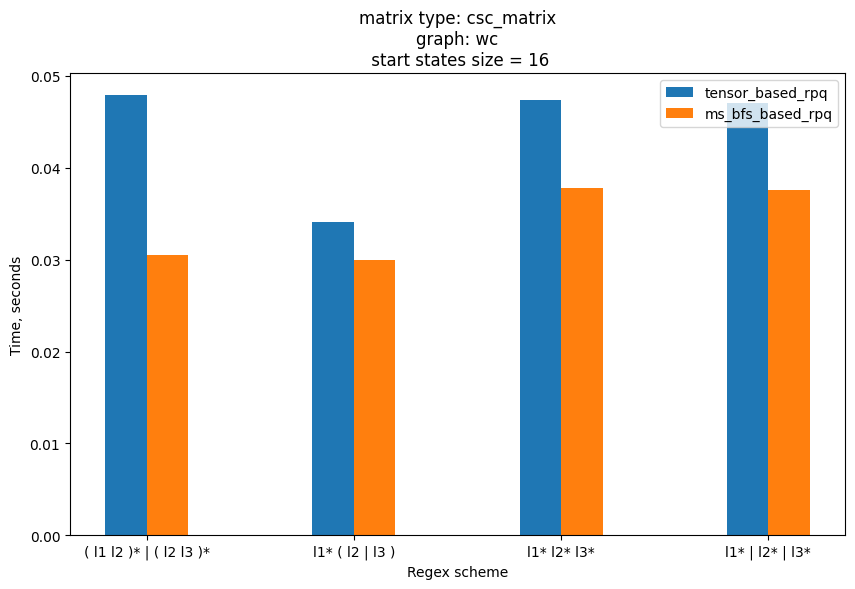

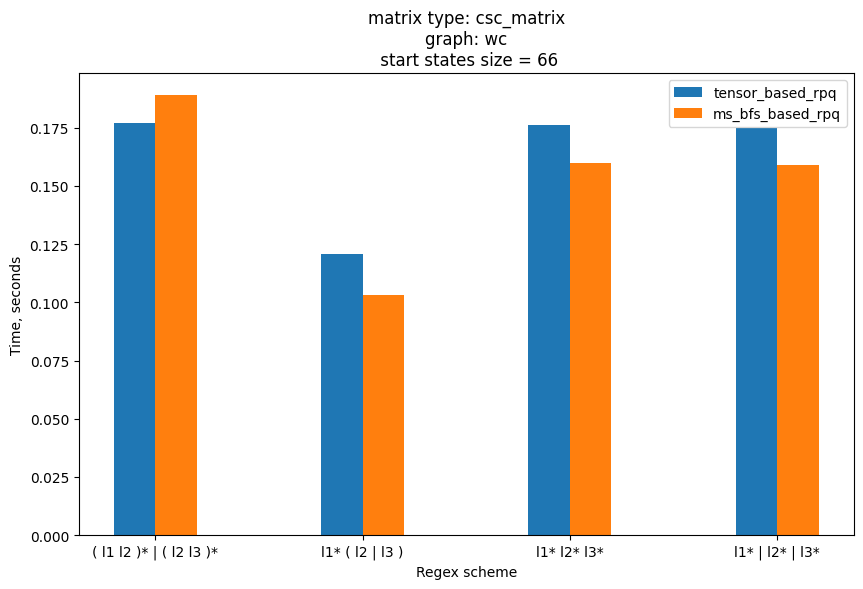

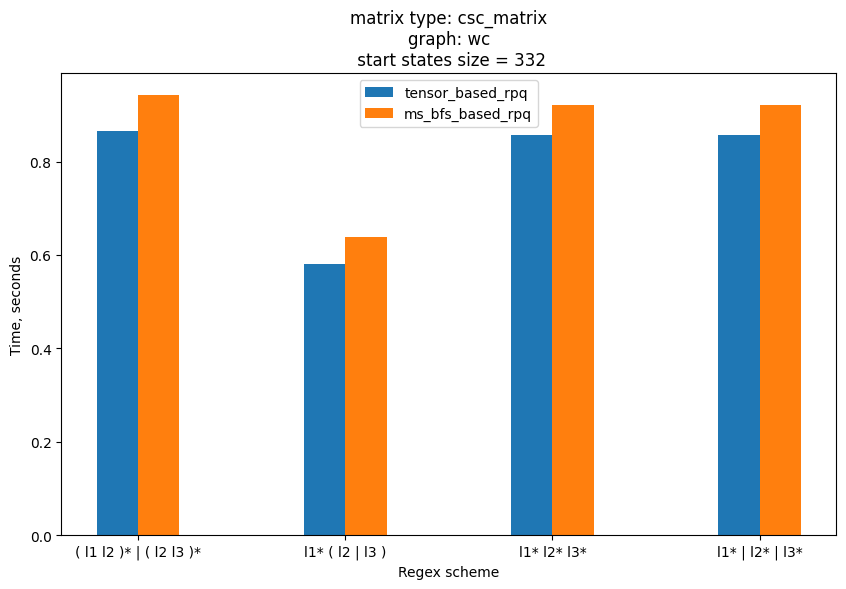

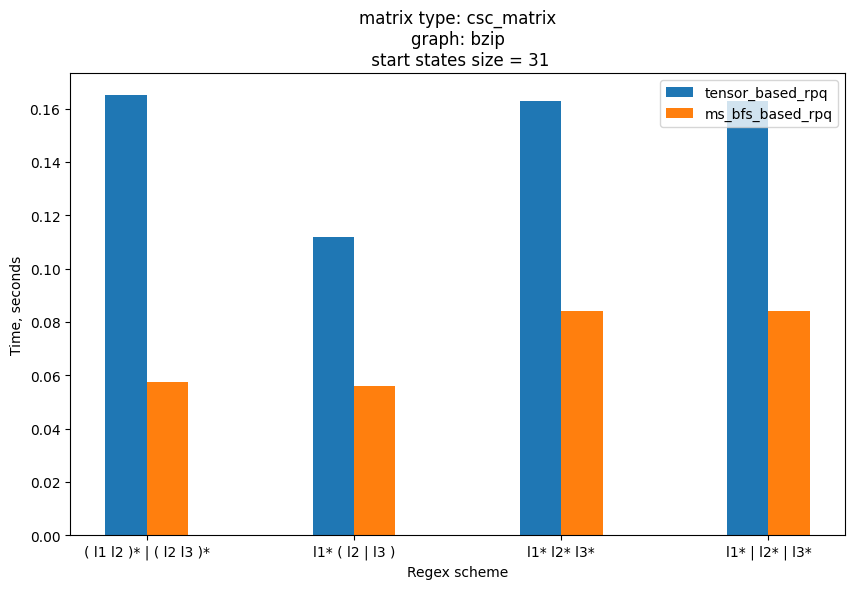

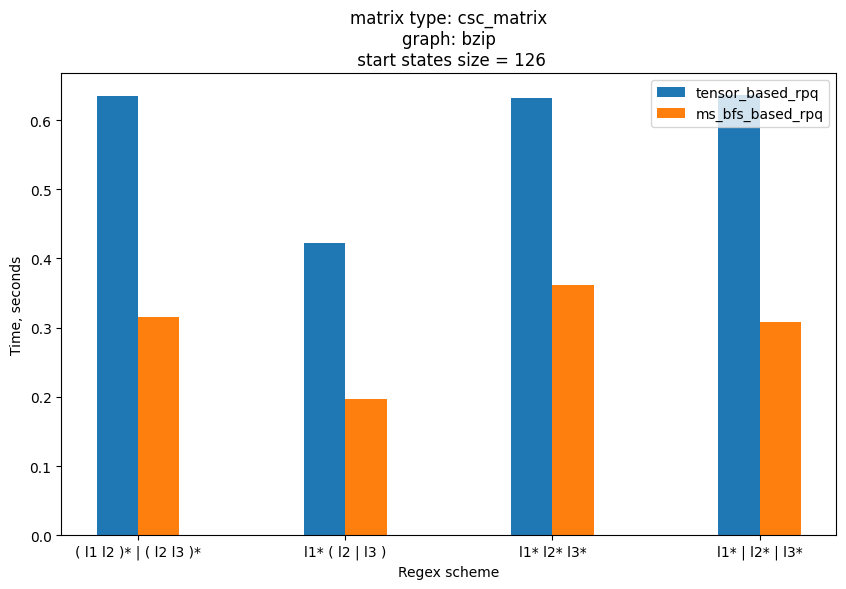

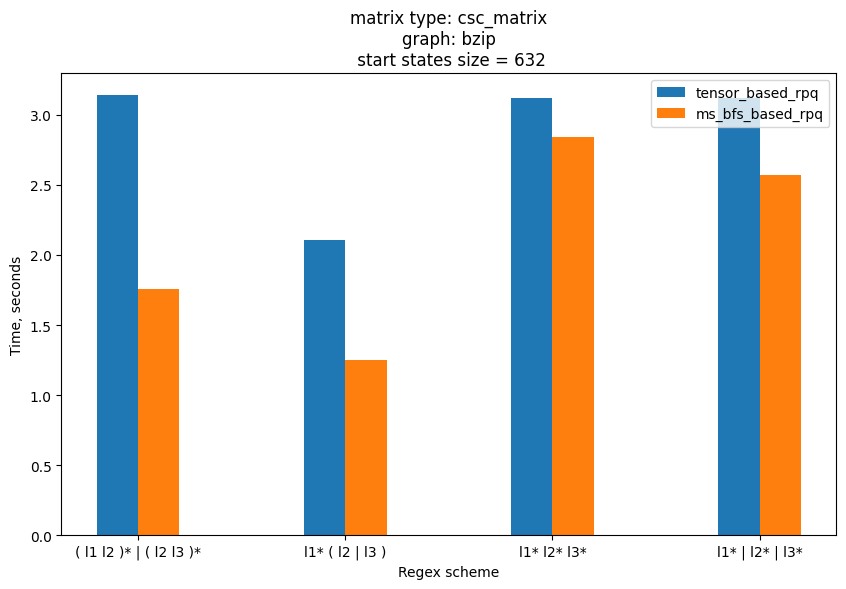

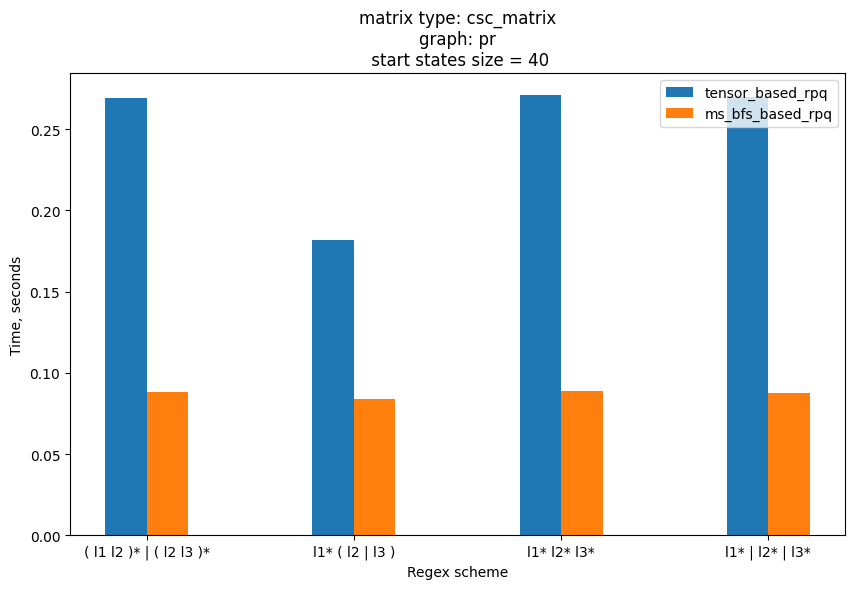

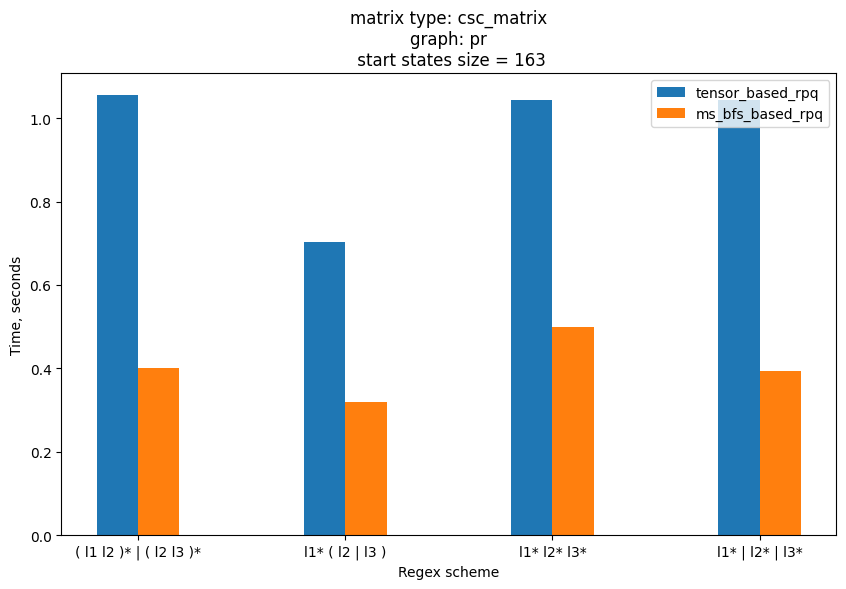

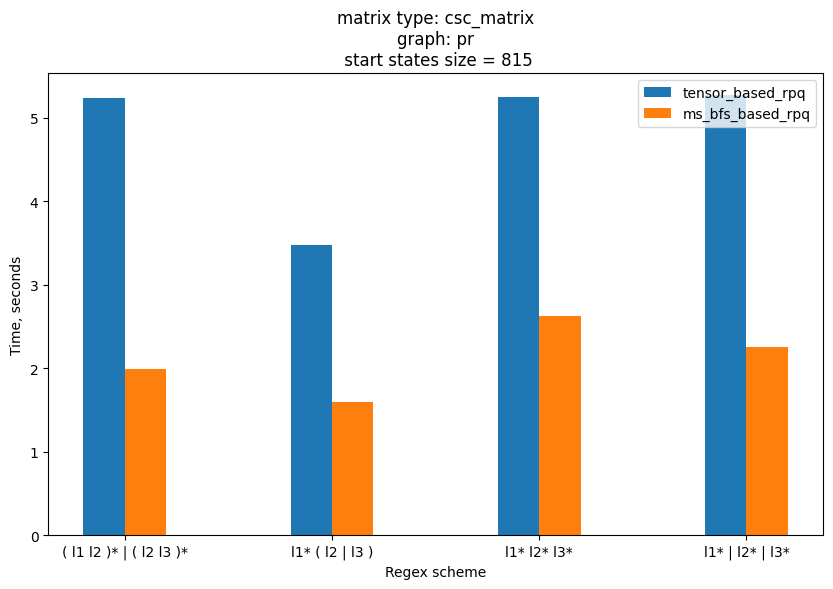

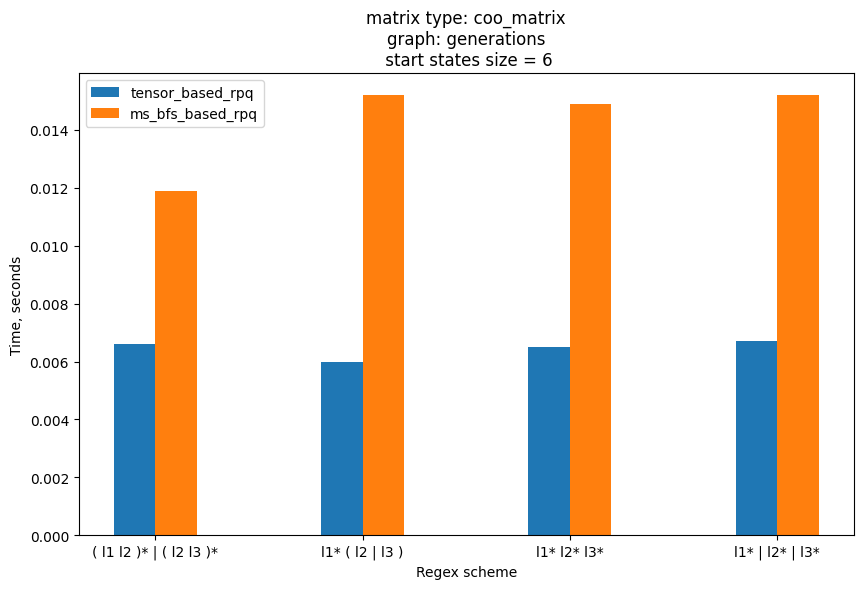

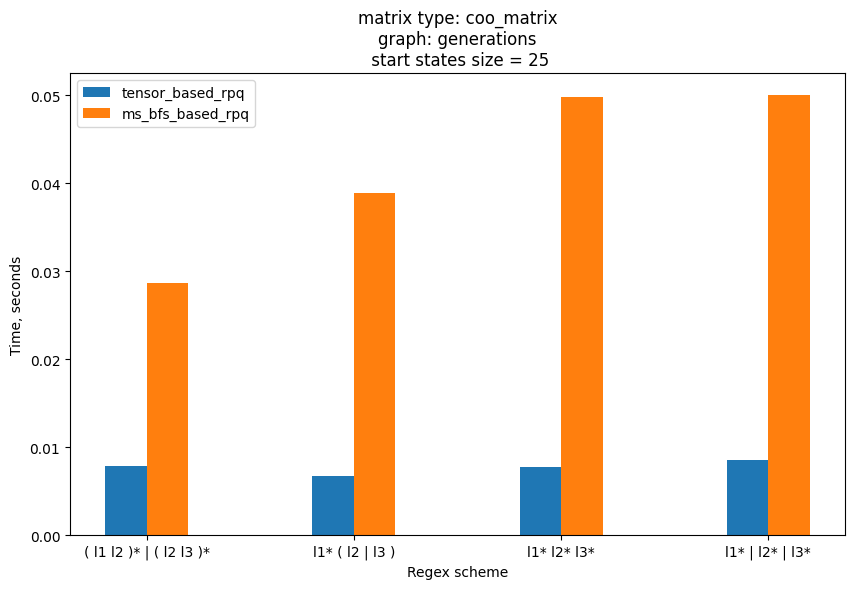

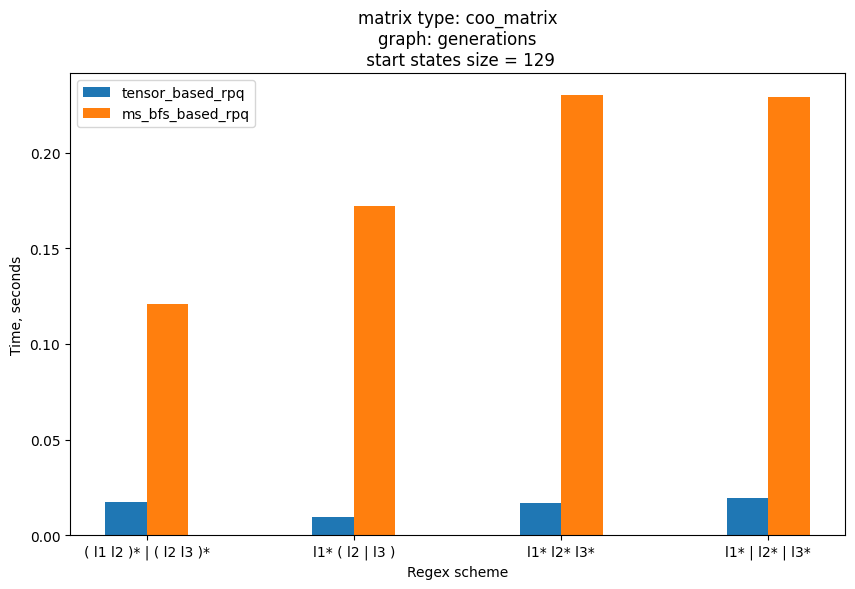

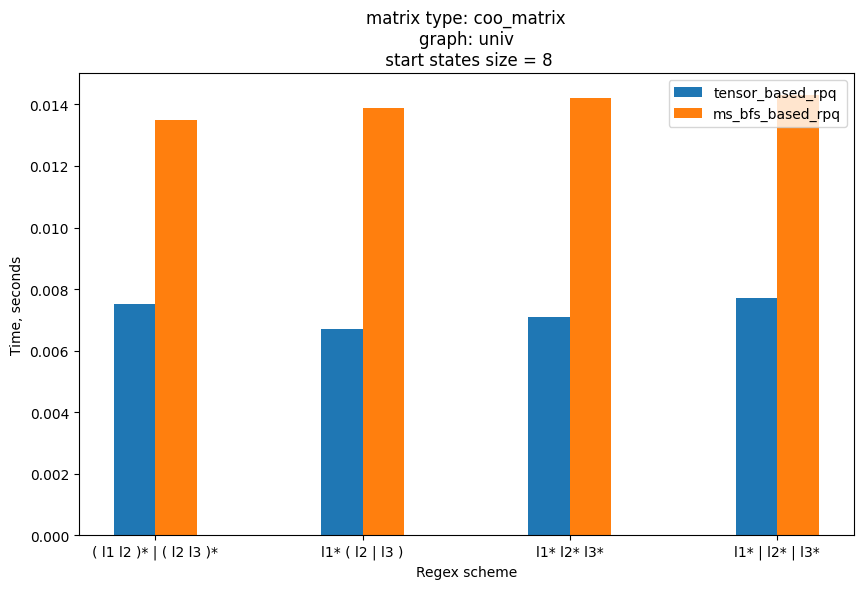

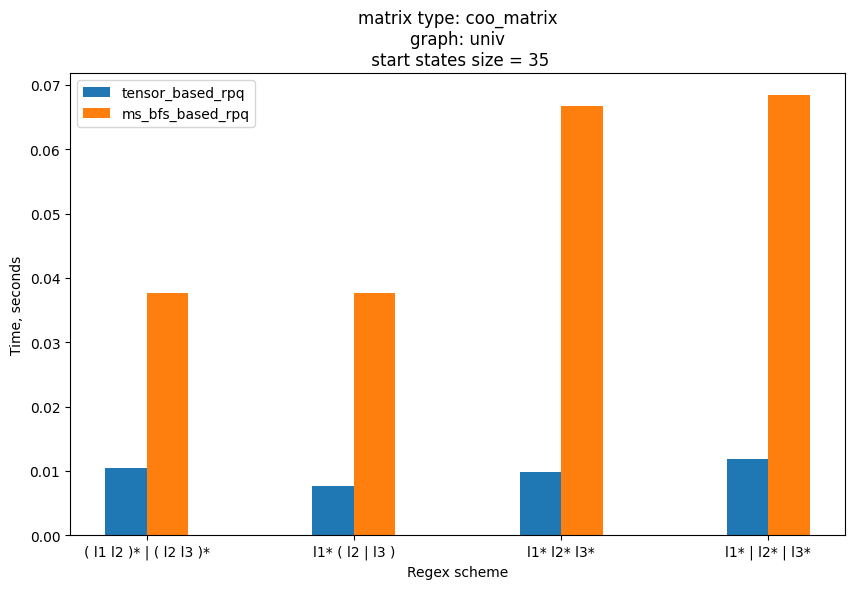

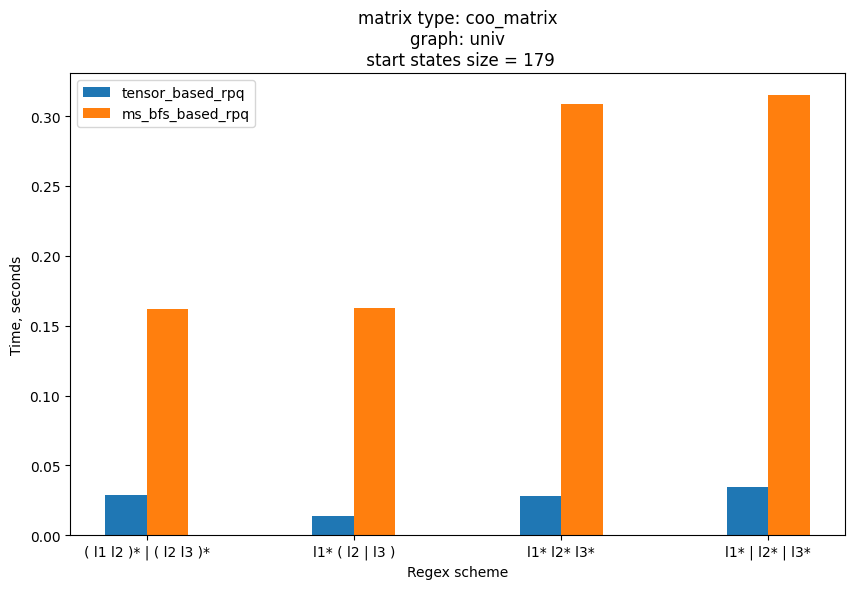

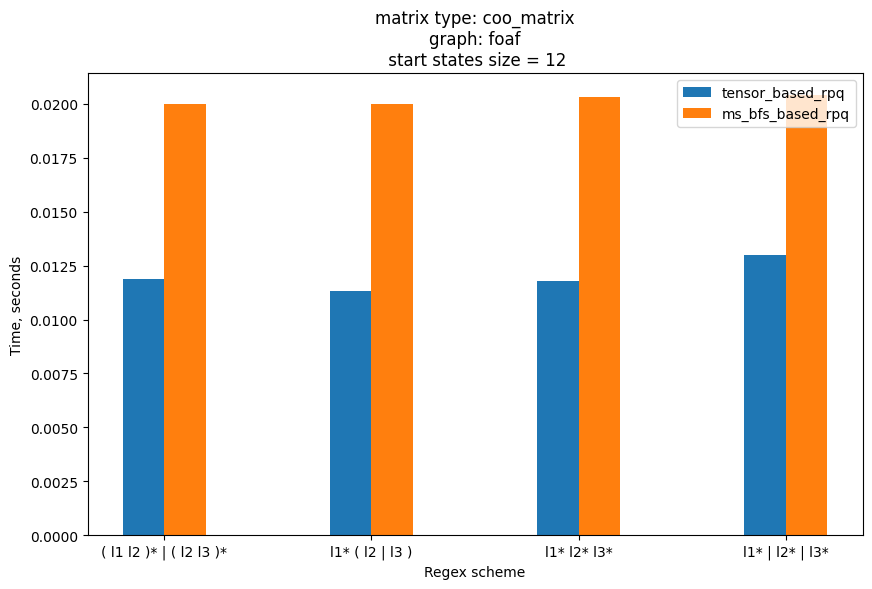

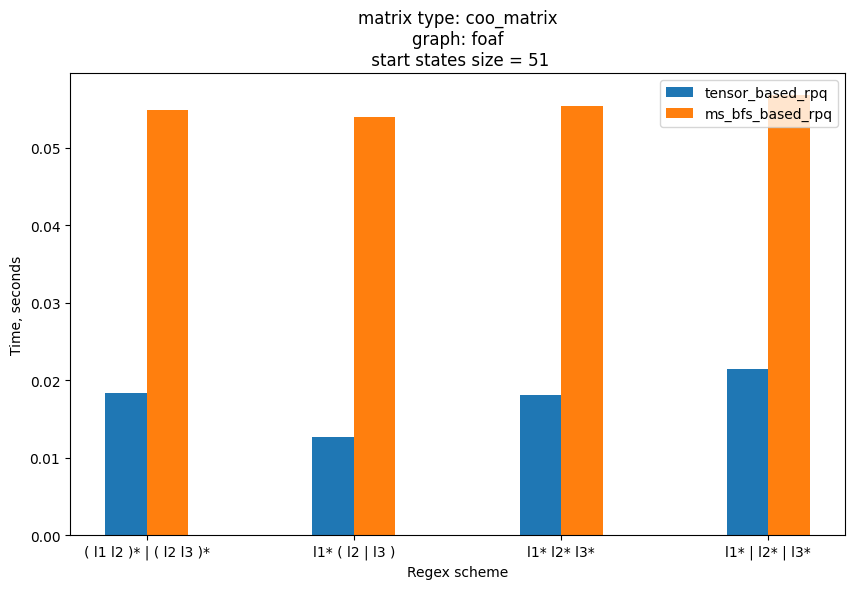

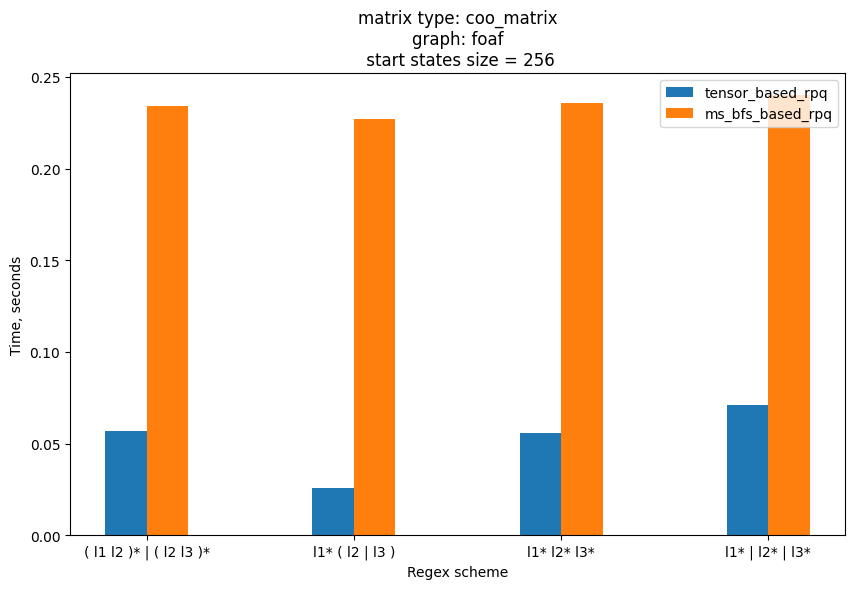

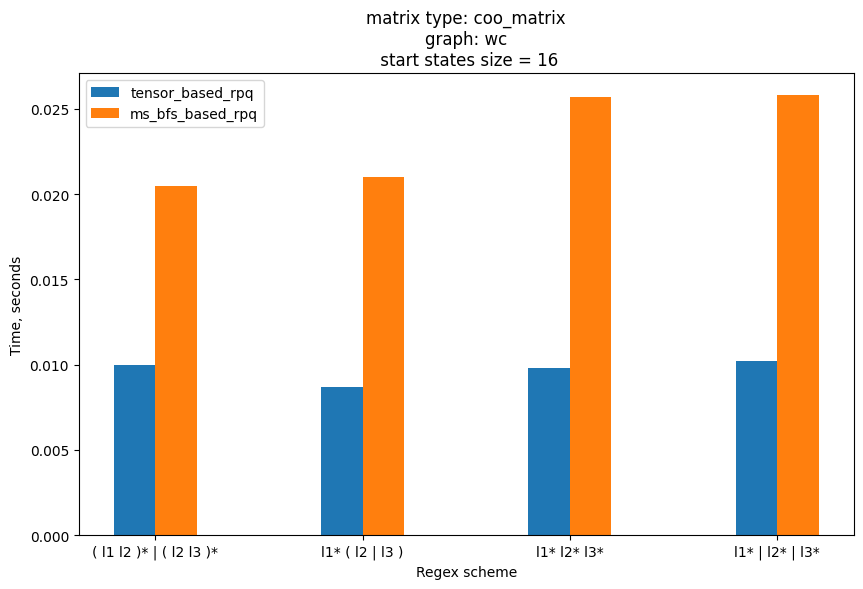

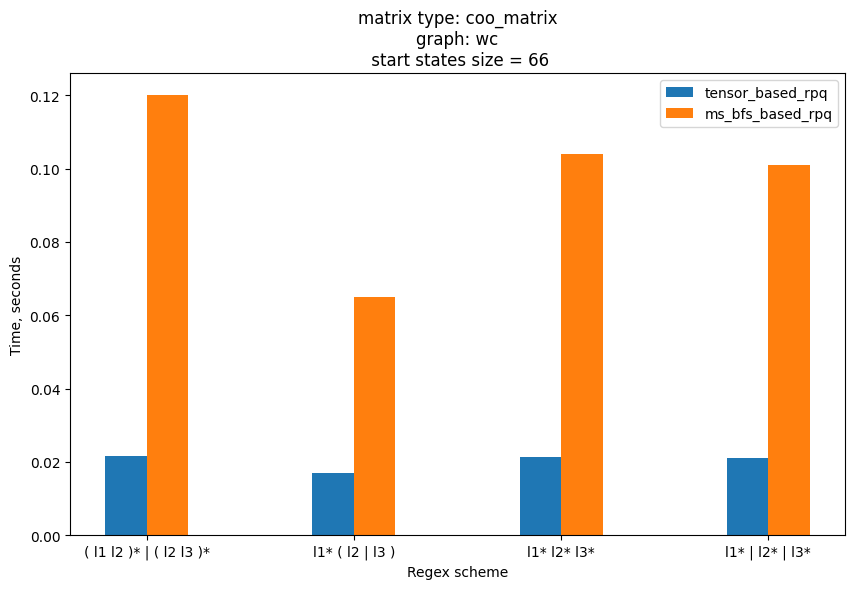

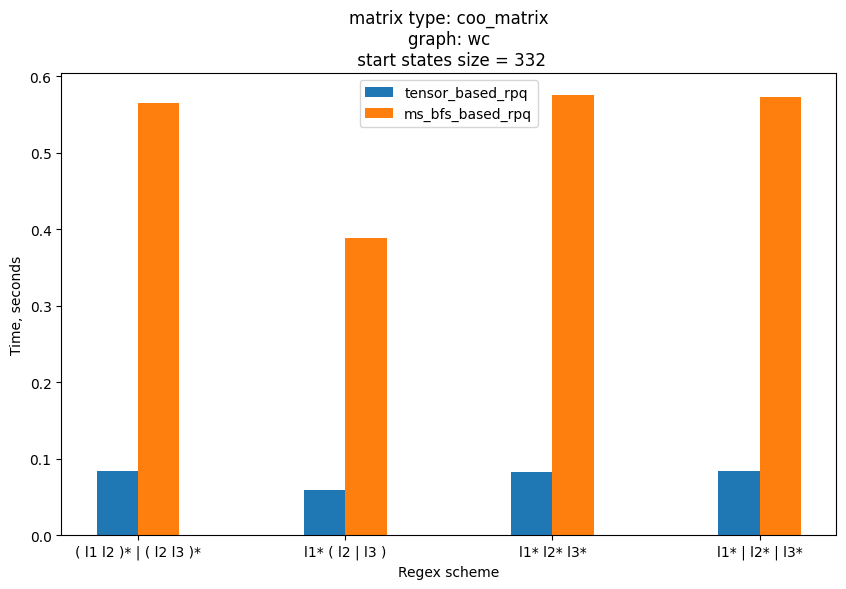

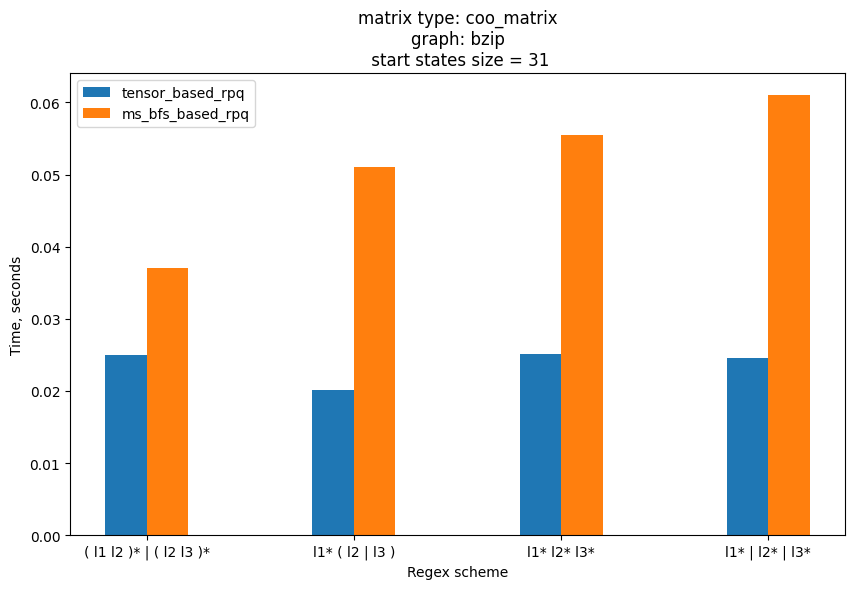

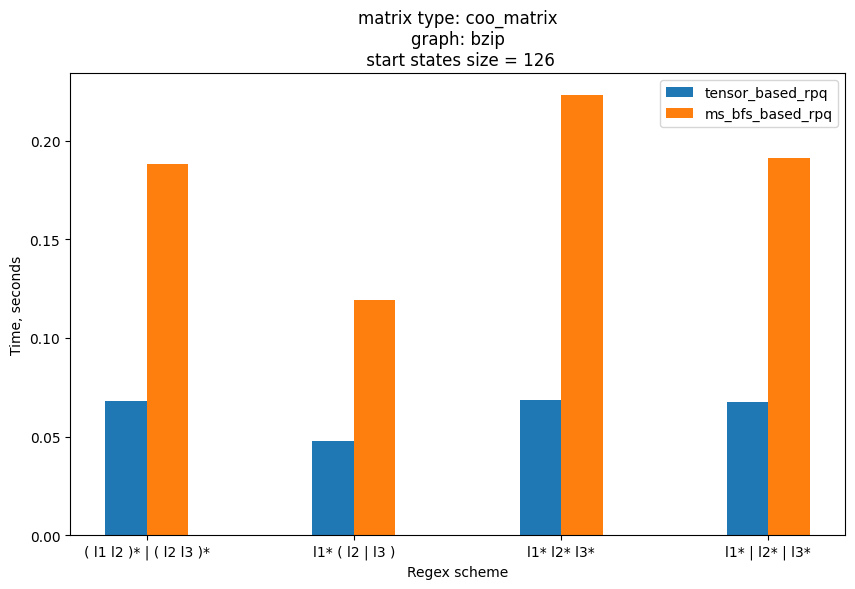

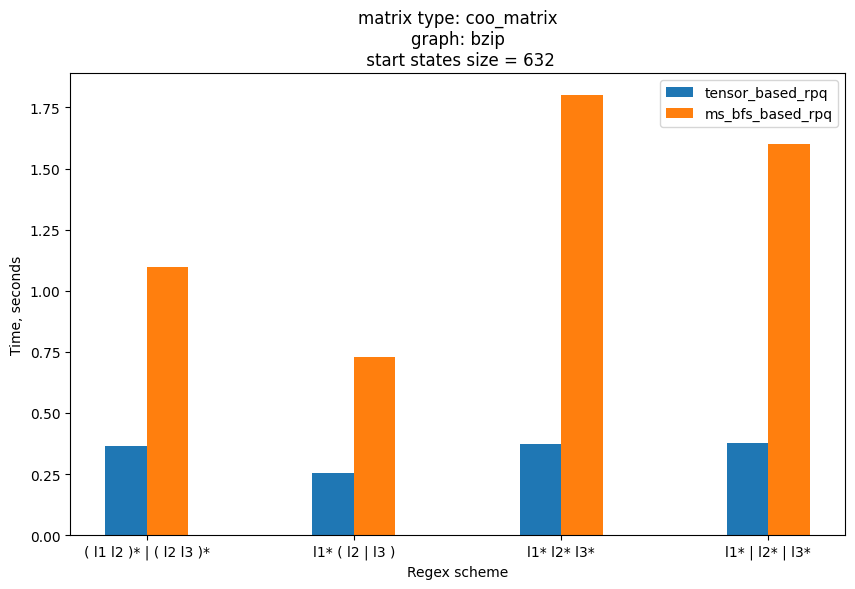

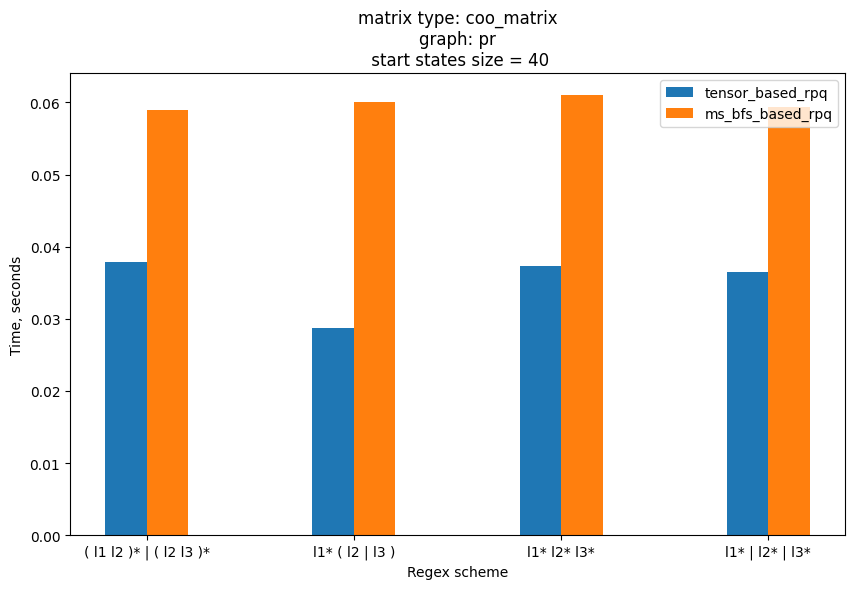

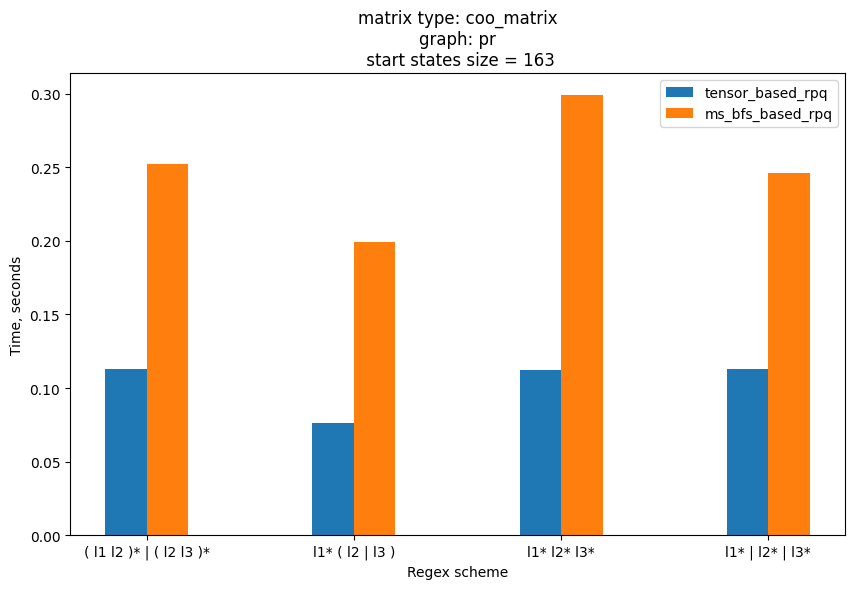

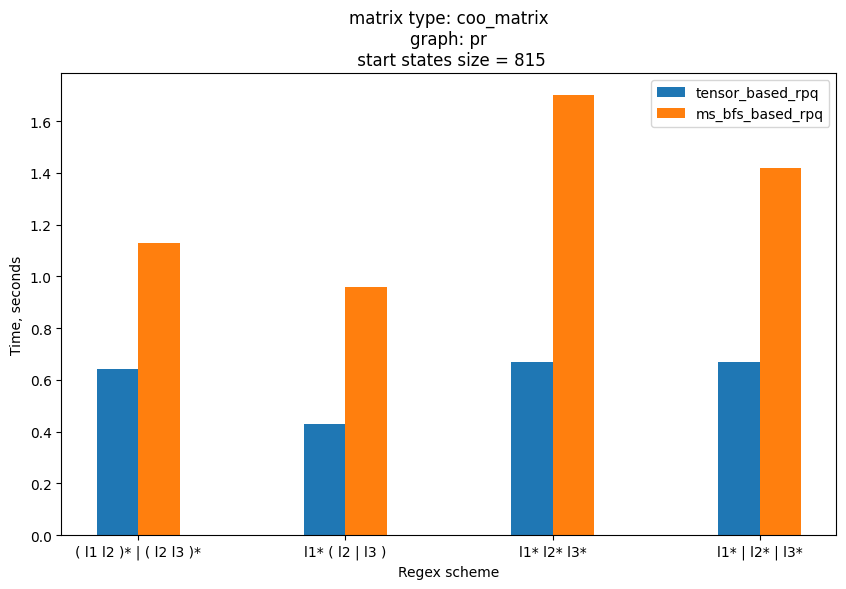

In [11]:
def plot_rpq_results(results):
    grouped_data = defaultdict(lambda: defaultdict(list))

    for result in results:
        key = (result.sparse_matrix_type, result.graph_name, result.start_nodes_number)
        grouped_data[key][result.regex_scheme].append(result)

    for (
        sparse_matrix_type,
        graph_name,
        start_nodes_number,
    ), regex_data in grouped_data.items():
        regex_schemes = sorted(regex_data.keys())

        x = np.arange(len(regex_schemes))
        width = 0.2
        fig, ax = plt.subplots(figsize=(10, 6))

        for i, algo_name in enumerate(RPQ_ALGOS):
            times = []
            for regex in regex_schemes:
                found = False
                for res in regex_data[regex]:
                    if res.algorithm_name == algo_name.__name__:
                        times.append(float(res.mean_time))
                        found = True
                        break
                if not found:
                    times.append(0.0)
            ax.bar(x + i * width, times, width, label=algo_name.__name__)

        ax.set_xlabel("Regex scheme")
        ax.set_ylabel("Time, seconds")
        ax.set_title(
            f"matrix type: {sparse_matrix_type}\ngraph: {graph_name}\n start states size = {start_nodes_number}"
        )
        ax.set_xticks(x + width * (len(RPQ_ALGOS) - 1) / 2)
        ax.set_xticklabels(regex_schemes)
        ax.legend()
        plt.show()


plot_rpq_results(results)